In [34]:
import pandas as pd
# from pandarallel import pandarallel

# Initialization
# pandarallel.initialize()
from tqdm import tqdm
tqdm.pandas()
import os
import json
import pywer
from pyjarowinkler import distance as jwdistance
from tqdm import tqdm

class Const:
    OCR = 'ocr'
    GROUND = 'groundtruth'
    LINE = 'line'
    SENTENCE = 'sentence'
    FILE = 'filename'
    DATASET = 'dataset_name'
    PREDICTION = 'prediction'
    PROMPT = 'prompt'
    LANGUAGE = 'language'
    NONE = None


### Lookup datasets

In [35]:
datasets = []

for type_document in ['ocr', 'asr']:
    for root, dirs, files in os.walk(f'../data/datasets/{type_document}/converted'):
        for file in files:
            if file.endswith(".jsonl"):
                input_file = os.path.join(root, file)
                if 'sample' not in input_file:
                    with open(input_file) as f:
                        lines = f.read().splitlines()
                    df_inter = pd.DataFrame(lines)
                    df_inter.columns = ['json_element']
                    df_inter['json_element'].apply(json.loads)
                    df = pd.json_normalize(df_inter['json_element'].apply(json.loads))

                    dataset_name = root.split('/')[-1].replace('_', '-')
                    print(input_file, dataset_name)
                    df['dataset_name'] = [dataset_name] * len(df)
                    if 'ajmc' in dataset_name:
                        df['language'] = ['el'] * len(df)
                    if 'overproof' in dataset_name:
                        df['language'] = ['en'] * len(df)
                    if 'impresso' in dataset_name:
                        df['language'] = ['de'] * len(df)

                    datasets.append(df)
            

../data/datasets/ocr/converted/AN/AN_lines.jsonl AN
../data/datasets/asr/converted/ina/ina_last.jsonl ina


## Step 1: Loading of Results


In [36]:
def read_line_by_line(filename):
    pass

def json_load(text):
    
    try:
        loaded_line = json.loads(text)
    except Exception as ex:
        print(ex)
        print(text[:30], '...')
        loaded_line = 'No text'
    return loaded_line

In [37]:
import gc; gc.collect()

5

In [38]:
from tqdm import tqdm
import os

results, results_backup = [], []

# First traversal to get count of .jsonl files
jsonl_count = 0
for root, dirs, files in os.walk('../data/output'):
    for file in files:
        if file.endswith(".jsonl"):
            jsonl_count += 1

# Second traversal to do the processing with tqdm progress bar
with tqdm(total=jsonl_count) as pbar:
    for root, dirs, files in os.walk('../data/output'):
        for file in files:
            if file.endswith(".jsonl"):
                input_file = os.path.join(root, file)
                is_few = False
                if 'few' in input_file:
                    prompt = root.split('/')[-2]
                    is_few = True
                else:
                    prompt = root.split('/')[-2]
                    
                if 'sample' not in input_file:
                    try:
                        with open(input_file) as f:
                            text = f.read()
                    
                        with open(input_file) as f:
                            lines = f.readlines()
                    except Exception as ex:
                        # sometimes, the results were in progress, so the jsonfile was not correct
                        print('We could not load {} {}'.format(input_file, ex))
                        continue
                    # Check correct lines
                    text = text.replace('\n', '')
                    text_list = text.split('}}{"')
                    json_objects = []

                    for i, t in enumerate(text_list):
                        if i != 0:
                            t = '{"' + t
                        if i != len(text_list) - 1:
                            t = t + '}'
                        if not t.endswith('}}'):
                            json_objects.append(t + '}\n')
                        else:
                            json_objects.append(t + '\n')
                        
                    df_inter = pd.DataFrame(json_objects)
                    df_inter.columns = ['json_element']

                    dataset_name = root.split('/')[-1].replace('_', '-')
                    model_dataset_name = file[8:-6]
                    model_name = model_dataset_name.replace(root.split('/')[-1] + '-', '').strip()
                    try:
                        df_inter['json_element'].apply(lambda x: json_load(x))
                        df = pd.json_normalize(df_inter['json_element'].apply(json.loads))

                        df['model'] = [model_name] * len(df)

                        df['dataset_name'] = [dataset_name] * len(df)
                        df['prompt'] = [prompt] * len(df)

                        with open(f'../data/prompts/{prompt}.txt', 'r') as f:
                            prompt_text = f.read()
                        prompt_text = prompt
                            
                        df['prompt_text'] = [prompt_text] * len(df)
                        
                        df['dataset_name'] = [dataset_name] * len(df)
                        
                        if 'ina' in dataset_name:
                            df['language'] = ['fr'] * len(df)
                        
                        df['file'] = file
                        
                        df['name_of_file_idx'] = df.index.to_series().apply(lambda i: f"{file}_{i}")
                    
                        results.append(df)
                        results_backup.append(df)
                    except Exception as ex:
                        print('We could not load {} {}'.format(input_file, ex))
                    pbar.update()


100%|████████████████████████████████████████| 112/112 [00:00<00:00, 121.09it/s]


Check one result:

In [39]:
for idx, result in tqdm(enumerate(results), total=len(results)):
    for _, item in result.iterrows():
        dataset_name = results[idx]['dataset_name'].unique()[0]
        text_types = ['line']

        for segment_type in text_types:
            if '{{TEXTE}}' in str(item[f'prediction.{segment_type}']):
                print(item['model'], item['dataset_name'], item['prompt'], item['type'])


100%|████████████████████████████████████████| 112/112 [00:01<00:00, 110.27it/s]


## Step 2:  Post-process the Results

In [40]:
import Levenshtein
from Levenshtein import distance

def compute_normalized_levenshtein_similarity(ground_truth_text, ocr_text):
    length = max(len(ocr_text), len(ground_truth_text))
    # Check if both strings are empty
    if length == 0:
        return 1.0
    levenshtein_distance = distance(ocr_text, ground_truth_text)
    similarity = (length - levenshtein_distance) / length
    return similarity

def get_improvement(original_similarity, corrected_similarity):
    
    if original_similarity == 0:
        return min(max(corrected_similarity, -1), 1)
    elif original_similarity != corrected_similarity:
        return min(max((corrected_similarity - original_similarity) / original_similarity, -1), 1)
    elif original_similarity == corrected_similarity:
        return 0
    else:
        return 0 if corrected_similarity < 1 else 1



### Post-process Methods

Read the prompts so they can be removed from the models' answers.

In [41]:
import glob

prompts = []

file_list = glob.glob('../data/prompts/**/*.txt', recursive=True)

prompts = [open(f).read() for f in file_list]

#prompts = [text[:text.index('{{TEXT}}')].strip() for text in prompts]

Other texts to remove, so we get the actual answer:

In [43]:
texts_to_remove = ""

In [44]:
def get_response(pred_text, ocr_text):
    if pred_text is not None:
        if type(pred_text) == str:
            if len(pred_text.strip()) > 0:
                if pred_text.startswith('"'):
                    pred_text = pred_text[1:]
                if pred_text.endswith('"'):
                    pred_text = pred_text[:-1]

            pred_text = pred_text.strip()
            
            processings = ''
            
            for prompt in prompts:
                prompt = prompt.strip()
                if prompt in pred_text:
                    index_of_last_occurrence = pred_text.lower().rfind(prompt.lower())
                    pred_text = pred_text[index_of_last_occurrence+len(prompt):].strip()
                    processings += 'PROMPT-REMOVED' + '|'

            for text in texts_to_remove:
                text = text.strip()
                if text in pred_text:
                    index_of_last_occurrence = pred_text.lower().rfind(text.lower())
                    pred_text = pred_text[index_of_last_occurrence+len(text):].strip()
                    processings += f'[{text}]-REMOVED' + '|'
            
            original_len = len(pred_text)
            # Enforce pred_text length limits relative to ocr_text
            max_length = int(len(ocr_text) * 1.5)
            if original_len > max_length:
                pred_text = pred_text[:max_length]
                processings += 'PRED-TEXT-TRUNCATED' + '|'
                    
            if 'There is no text provided to correct'.lower() in pred_text.lower():
                return ocr_text, '[There is no text provided to correct]-ANSWER'
            if 'No correction needed'.lower() in pred_text.lower():
                return ocr_text, '[No correction needed]-ANSWER'
            
            # this last case will never happen - the data was re-run
            if '{{TEXTE}}'.lower() in pred_text.lower():
                return ocr_text, '{{TEXTE}}'
    
    if len(processings.strip()) < 2:
        processings = 'NONE'
        
    return pd.Series([str(pred_text).strip(), processings.strip()])  

def postprocess_segment_type(segment_type):
    def postprocess(row):
        pred_text = str(row[f'prediction.{segment_type}'])
        ground_text = str(row[f'groundtruth.{segment_type}'])
        ocr_text = str(row[f'ocr.{segment_type}'])
        prompt_text = str(row['prompt_text'])
        
        pred_text = get_response(pred_text, ocr_text)
        
        return pred_text
    return postprocess

In [45]:
MODEL_MAP = {'gpt-4.1':'GPT-4.1',
             'gpt-3.5-turbo':'GPT-3.5', 
             'gpt-4.1-mini' : 'GPT-4.1-MINI',
             'google/gemma-3-27b-it': 'GEMMA-3-27B',
             'meta-llama/llama-4-scout-17b-16e-instruct': 'LLAMA-4-SCOUT-17B',
             'meta-llama/llama-4-maverick-17b-128e-instruct-fp8': 'LLAMA-4-MAVERICK-17B',
             'deepseek/deepseek-v3-turbo': 'DEEPSEEK-V3'
            }

# Define OCR noise level bins
bins = [0, 0.4, 0.6, 0.8, 0.99, 1.0]

# Assign OCR noise level labels
labels = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]

# Custom binning function
def bin_improvement(x):
    if x < 0:
        return "Negative Improvement"
    elif x == 0:
        return "No Improvement"
    elif x > 0:
        return "Positive Improvement"



In [46]:
import os

path = '../data/processed_data'
os.makedirs(path, exist_ok=True)


Not removing anymore the columns with < 1 token, but adding new columns for number of tokens and number of characters + mapping of the models' names to more understandable names.

In [47]:
def count_tokens(text):
    return len(text.split(' '))

for idx, result in tqdm(enumerate(results), total=len(results)):
    print('idx', idx)
    try:
        results[idx] = results[idx].fillna('No text')
    except:
        print(idx)
        pass
    
    try:
        results[idx]['model'] = results[idx]['model'].apply(lambda x: MODEL_MAP[x])
    except:
        print("Models already mapped.")
        
    dataset_name = results[idx]['dataset_name'].unique()[0]
    model_name = results[idx]['model'].unique()[0]
    prompt = results[idx]['prompt'].unique()[0]
    prompt_text = results[idx]['prompt_text'].unique()[0]
    
    print('Dataset:', dataset_name, 'Model:', model_name, 'Prompt:', prompt, 'Prompt text:', prompt_text)
    
    text_types = ['line']
    for segment_type in text_types:

        postprocess = postprocess_segment_type(segment_type)
        
        # Keeping the original un-processed column
        try:
            results[idx][[f'prediction.{segment_type}.postprocessed','post-processings']] = results[idx].apply(postprocess, axis=1)
        except Exception as ex:
            print(f'-------Problem encountered at {idx}.', ex)
            
        
    print(f'Saving to ../data/processed_data/{dataset_name}_{prompt_text}_{model_name}.csv')
 #   results[idx].to_csv(f"../data/processed_data/{dataset_name}_{prompt_text}_{model_name}.parquet") 
    
    

 13%|█████▍                                   | 15/112 [00:00<00:00, 132.69it/s]

idx 0
Models already mapped.
Dataset: AN-lines Model: gpt-3.5-turbo-temp0.05 Prompt: prompt_basic_02 Prompt text: prompt_basic_02
Saving to ../data/processed_data/AN-lines_prompt_basic_02_gpt-3.5-turbo-temp0.05.csv
idx 1
Models already mapped.
Dataset: AN-lines Model: deepseek-deepseek-v3-turbo-temp0.7 Prompt: prompt_basic_02 Prompt text: prompt_basic_02
Saving to ../data/processed_data/AN-lines_prompt_basic_02_deepseek-deepseek-v3-turbo-temp0.7.csv
idx 2
Models already mapped.
Dataset: AN-lines Model: gpt-4.1-temp0.7 Prompt: prompt_basic_02 Prompt text: prompt_basic_02
Saving to ../data/processed_data/AN-lines_prompt_basic_02_gpt-4.1-temp0.7.csv
idx 3
Models already mapped.
Dataset: AN-lines Model: meta-llama-llama-4-maverick-17b-128e-instruct-fp8-temp0.7 Prompt: prompt_basic_02 Prompt text: prompt_basic_02
Saving to ../data/processed_data/AN-lines_prompt_basic_02_meta-llama-llama-4-maverick-17b-128e-instruct-fp8-temp0.7.csv
idx 4
Models already mapped.
Dataset: AN-lines Model: meta-l

 41%|█████████████████▎                        | 46/112 [00:00<00:00, 87.63it/s]

idx 29
Models already mapped.
Dataset: AN-lines Model: deepseek-deepseek-v3-turbo-temp0.7 Prompt: prompt_complex_01 Prompt text: prompt_complex_01
Saving to ../data/processed_data/AN-lines_prompt_complex_01_deepseek-deepseek-v3-turbo-temp0.7.csv
idx 30
Models already mapped.
Dataset: AN-lines Model: gpt-4.1-temp0.7 Prompt: prompt_complex_01 Prompt text: prompt_complex_01
Saving to ../data/processed_data/AN-lines_prompt_complex_01_gpt-4.1-temp0.7.csv
idx 31
Models already mapped.
Dataset: AN-lines Model: meta-llama-llama-4-maverick-17b-128e-instruct-fp8-temp0.7 Prompt: prompt_complex_01 Prompt text: prompt_complex_01
Saving to ../data/processed_data/AN-lines_prompt_complex_01_meta-llama-llama-4-maverick-17b-128e-instruct-fp8-temp0.7.csv
idx 32
Models already mapped.
Dataset: AN-lines Model: meta-llama-llama-4-scout-17b-16e-instruct-temp0.05 Prompt: prompt_complex_01 Prompt text: prompt_complex_01
Saving to ../data/processed_data/AN-lines_prompt_complex_01_meta-llama-llama-4-scout-17b-16

 52%|█████████████████████▊                    | 58/112 [00:00<00:00, 73.52it/s]

Saving to ../data/processed_data/ina-last_prompt_complex_01_meta-llama-llama-4-maverick-17b-128e-instruct-fp8-temp0.70.csv
idx 50
Models already mapped.
Dataset: ina-last Model: gpt-4.1-mini-temp0.05 Prompt: prompt_complex_01 Prompt text: prompt_complex_01
Saving to ../data/processed_data/ina-last_prompt_complex_01_gpt-4.1-mini-temp0.05.csv
idx 51
Models already mapped.
Dataset: ina-last Model: gpt-3.5-turbo-temp0.05 Prompt: prompt_complex_01 Prompt text: prompt_complex_01
Saving to ../data/processed_data/ina-last_prompt_complex_01_gpt-3.5-turbo-temp0.05.csv
idx 52
Models already mapped.
Dataset: ina-last Model: gpt-4.1-temp0.70 Prompt: prompt_complex_01 Prompt text: prompt_complex_01
Saving to ../data/processed_data/ina-last_prompt_complex_01_gpt-4.1-temp0.70.csv
idx 53
Models already mapped.
Dataset: ina-last Model: google-gemma-3-27b-it-temp0.70 Prompt: prompt_complex_01 Prompt text: prompt_complex_01
Saving to ../data/processed_data/ina-last_prompt_complex_01_google-gemma-3-27b-it-

 65%|███████████████████████████▍              | 73/112 [00:00<00:00, 88.35it/s]

idx 73
Models already mapped.
Dataset: ina-last Model: gpt-4.1-temp0.7 Prompt: prompt_basic_01 Prompt text: prompt_basic_01
Saving to ../data/processed_data/ina-last_prompt_basic_01_gpt-4.1-temp0.7.csv
idx 74
Models already mapped.
Dataset: ina-last Model: meta-llama-llama-4-scout-17b-16e-instruct-temp0.05 Prompt: prompt_basic_01 Prompt text: prompt_basic_01
Saving to ../data/processed_data/ina-last_prompt_basic_01_meta-llama-llama-4-scout-17b-16e-instruct-temp0.05.csv
idx 75
Models already mapped.
Dataset: ina-last Model: deepseek-deepseek-v3-turbo-temp0.05 Prompt: prompt_basic_01 Prompt text: prompt_basic_01
Saving to ../data/processed_data/ina-last_prompt_basic_01_deepseek-deepseek-v3-turbo-temp0.05.csv
idx 76
Models already mapped.
Dataset: ina-last Model: google-gemma-3-27b-it-temp0.05 Prompt: prompt_basic_01 Prompt text: prompt_basic_01
Saving to ../data/processed_data/ina-last_prompt_basic_01_google-gemma-3-27b-it-temp0.05.csv
idx 77
Models already mapped.
Dataset: ina-last Mode

 91%|█████████████████████████████████████▎   | 102/112 [00:01<00:00, 91.87it/s]

Dataset: ina-last Model: meta-llama-llama-4-scout-17b-16e-instruct-temp0.7 Prompt: prompt_basic_01 Prompt text: prompt_basic_01
Saving to ../data/processed_data/ina-last_prompt_basic_01_meta-llama-llama-4-scout-17b-16e-instruct-temp0.7.csv
idx 84
Models already mapped.
Dataset: AN-lines Model: gpt-3.5-turbo-temp0.05 Prompt: prompt_complex_02 Prompt text: prompt_complex_02
Saving to ../data/processed_data/AN-lines_prompt_complex_02_gpt-3.5-turbo-temp0.05.csv
idx 85
Models already mapped.
Dataset: AN-lines Model: deepseek-deepseek-v3-turbo-temp0.7 Prompt: prompt_complex_02 Prompt text: prompt_complex_02
Saving to ../data/processed_data/AN-lines_prompt_complex_02_deepseek-deepseek-v3-turbo-temp0.7.csv
idx 86
Models already mapped.
Dataset: AN-lines Model: gpt-4.1-temp0.7 Prompt: prompt_complex_02 Prompt text: prompt_complex_02
Saving to ../data/processed_data/AN-lines_prompt_complex_02_gpt-4.1-temp0.7.csv
idx 87
Models already mapped.
Dataset: AN-lines Model: meta-llama-llama-4-maverick-1

100%|█████████████████████████████████████████| 112/112 [00:01<00:00, 78.95it/s]

Dataset: ina-last Model: gpt-3.5-turbo-temp0.7 Prompt: prompt_complex_02 Prompt text: prompt_complex_02
Saving to ../data/processed_data/ina-last_prompt_complex_02_gpt-3.5-turbo-temp0.7.csv
idx 107
Models already mapped.
Dataset: ina-last Model: deepseek-deepseek-v3-turbo-temp0.7 Prompt: prompt_complex_02 Prompt text: prompt_complex_02
Saving to ../data/processed_data/ina-last_prompt_complex_02_deepseek-deepseek-v3-turbo-temp0.7.csv
idx 108
Models already mapped.
Dataset: ina-last Model: gpt-4.1-mini-temp0.05 Prompt: prompt_complex_02 Prompt text: prompt_complex_02
Saving to ../data/processed_data/ina-last_prompt_complex_02_gpt-4.1-mini-temp0.05.csv
idx 109
Models already mapped.
Dataset: ina-last Model: gpt-4.1-mini-temp0.7 Prompt: prompt_complex_02 Prompt text: prompt_complex_02
Saving to ../data/processed_data/ina-last_prompt_complex_02_gpt-4.1-mini-temp0.7.csv
idx 110
Models already mapped.
Dataset: ina-last Model: gpt-3.5-turbo-temp0.05 Prompt: prompt_complex_02 Prompt text: promp

In [48]:
for segment_type in ['line']:

    results[1][[f'prediction.{segment_type}.postprocessed','post-processings']] = results[1].apply(postprocess, axis=1)


In [49]:
f'prediction.{segment_type}.postprocessed' in results[0].columns


True

In [50]:
for idx, df in tqdm(enumerate(results), total=len(results)):
    for segment_type in ['region', 'sentence']:
        if f'prediction.{segment_type}.postprocessed' not in df.columns:
            print('--', idx)


100%|██████████████████████████████████████| 112/112 [00:00<00:00, 11380.72it/s]

-- 0
-- 0
-- 1
-- 1
-- 2
-- 2
-- 3
-- 3
-- 4
-- 4
-- 5
-- 5
-- 6
-- 6
-- 7
-- 7
-- 8
-- 8
-- 9
-- 9
-- 10
-- 10
-- 11
-- 11
-- 12
-- 12
-- 13
-- 13
-- 14
-- 14
-- 15
-- 15
-- 16
-- 16
-- 17
-- 17
-- 18
-- 18
-- 19
-- 19
-- 20
-- 20
-- 21
-- 21
-- 22
-- 22
-- 23
-- 23
-- 24
-- 24
-- 25
-- 25
-- 26
-- 26
-- 27
-- 27
-- 28
-- 28
-- 29
-- 29
-- 30
-- 30
-- 31
-- 31
-- 32
-- 32
-- 33
-- 33
-- 34
-- 34
-- 35
-- 35
-- 36
-- 36
-- 37
-- 37
-- 38
-- 38
-- 39
-- 39
-- 40
-- 40
-- 41
-- 41
-- 42
-- 42
-- 43
-- 43
-- 44
-- 44
-- 45
-- 45
-- 46
-- 46
-- 47
-- 47
-- 48
-- 48
-- 49
-- 49
-- 50
-- 50
-- 51
-- 51
-- 52
-- 52
-- 53
-- 53
-- 54
-- 54
-- 55
-- 55
-- 56
-- 56
-- 57
-- 57
-- 58
-- 58
-- 59
-- 59
-- 60
-- 60
-- 61
-- 61
-- 62
-- 62
-- 63
-- 63
-- 64
-- 64
-- 65
-- 65
-- 66
-- 66
-- 67
-- 67
-- 68
-- 68
-- 69
-- 69
-- 70
-- 70
-- 71
-- 71
-- 72
-- 72
-- 73
-- 73
-- 74
-- 74
-- 75
-- 75
-- 76
-- 76
-- 77
-- 77
-- 78
-- 78
-- 79
-- 79
-- 80
-- 80
-- 81
-- 81
-- 82
-- 82
-- 83
-- 83
-- 84
-- 84


In [51]:
import gc; gc.collect()

0

In [54]:
import glob
from tqdm import tqdm

all_results = []
for idx, result in tqdm(enumerate(results), total=len(results)):

    # Extract basic metadata
    dataset_name = results[idx]['dataset_name'].unique()[0]
    model_name = results[idx]['model'].unique()[0]
    prompt = results[idx]['prompt'].unique()[0]
    prompt_text = results[idx]['prompt_text'].unique()[0]    
    # Define the text types to process (excluding "region")

    text_types = ['line']
        
    # Process only the allowed text_types
    for segment_type in text_types:
        results[idx][f'{segment_type}-lev-ocr'] = results[idx].apply(
            lambda x: compute_normalized_levenshtein_similarity(
                x[f'groundtruth.{segment_type}'],
                x[f'ocr.{segment_type}']
            ), axis=1
        )

        results[idx][f'{segment_type}-lev-pred'] = results[idx].apply(
            lambda x: compute_normalized_levenshtein_similarity(
                x[f'groundtruth.{segment_type}'],
                x[f'prediction.{segment_type}']
            ), axis=1
        )

        results[idx][f'{segment_type}-lev-improvement'] = results[idx].apply(
            lambda x: get_improvement(
                x[f'{segment_type}-lev-ocr'],
                x[f'{segment_type}-lev-pred']
            ), axis=1
        )
    
        # Create a quality band for OCR noise
        results[idx][f"quality-band-{segment_type}"] = pd.cut(
            results[idx][f'{segment_type}-lev-ocr'],
            bins=bins, 
            labels=labels, 
            include_lowest=True
        )

        results[idx][f'{segment_type}-lev-pred-postprocessed'] = results[idx].apply(
            lambda x: compute_normalized_levenshtein_similarity(
                x[f'groundtruth.{segment_type}'],
                x[f'prediction.{segment_type}.postprocessed']
            ), axis=1
        )

        results[idx][f'{segment_type}-lev-improvement-postprocessed'] = results[idx].apply(
            lambda x: get_improvement(
                x[f'{segment_type}-lev-ocr'],
                x[f'{segment_type}-lev-pred-postprocessed']
            ), axis=1
        )
    
    # Compute overall metrics without taking region into account
        # For other datasets, aggregate over "line" and "sentence"
    results[idx]['overall-levenshtein-improvement'] = results[idx][['line-lev-improvement']].mean(axis=1)
    results[idx]['overall-levenshtein-improvement-postprocessed'] = results[idx][['line-lev-improvement-postprocessed']].mean(axis=1)
    results[idx]['overall-lev-ocr'] = results[idx][['line-lev-ocr']].mean(axis=1)
    
        
    # Create a bin for overall improvement
    results[idx]['improvement-band'] = results[idx]['overall-levenshtein-improvement'].apply(bin_improvement)
    
    # Ensure that any "region" related columns are removed from the final DataFrame.
    region_cols = [col for col in results[idx].columns if 'region' in col]
    results[idx].drop(columns=region_cols, inplace=True)
    results[idx].drop(columns='prediction.prompt', errors='ignore', inplace=True)
    # Save the DataFrame (now without any region columns)
    #results[idx].to_parquet(f"../data/processed_data/{dataset_name}_{run_type}_{prompt_text}_{model_name}-final.parquet")
    # Optionally, you can save as CSV:
    results[idx].to_csv(f"../data/processed_data/{dataset_name}_{prompt_text}_{model_name}-final.csv")
    all_results.append(results[idx])




100%|█████████████████████████████████████████| 112/112 [00:01<00:00, 63.80it/s]


### Conca CSV

In [55]:
mega_df = pd.concat(all_results, ignore_index=True)
mega_df.tail()

,filename,language,dataset_name,ocr.line,ocr.sentence,groundtruth.line,groundtruth.sentence,prediction.line,model,prompt,...,line-lev-pred,line-lev-improvement,quality-band-line,line-lev-pred-postprocessed,line-lev-improvement-postprocessed,overall-levenshtein-improvement,overall-levenshtein-improvement-postprocessed,overall-lev-ocr,improvement-band,prediction.sentence
30223,../../data/datasets/asr/original/ina/4_impress...,fr,ina-last,enfin la météorologie ce soir nous a fait savo...,bien sûr pour tout renseignement vous pouvez n...,Enfin la météorologie ce soir nous a fait savo...,"Bien sûr, pour tout renseignement, vous pouvez...","Voici le texte corrigé :\n\nEnfin, la météorol...",meta-llama-llama-4-scout-17b-16e-instruct-temp0.7,prompt_complex_02,...,0.741641,-0.232704,80-99%,0.741641,-0.232704,-0.232704,-0.232704,0.966565,Negative Improvement,"Voici le texte corrigé :\n\nBien sûr, pour tou..."
30224,../../data/datasets/asr/original/ina/4_impress...,fr,ina-last,et puis comme chaque week end trop de morts su...,et puis comme chaque week end trop de morts su...,Et puis comme chaque week-end trop de morts su...,Et puis comme chaque week-end trop de morts su...,"Voici le texte corrigé :\n\nEt puis, comme cha...",meta-llama-llama-4-scout-17b-16e-instruct-temp0.7,prompt_complex_02,...,0.815166,-0.128616,80-99%,0.815166,-0.128616,-0.128616,-0.128616,0.935484,Negative Improvement,"Voici le texte corrigé :\n\nEt puis, comme cha..."
30225,../../data/datasets/asr/original/ina/4_impress...,fr,ina-last,le tiercé il fallait jouer le quatorze lasse l...,le tiercé il fallait jouer le quatorze lasse l...,"Le tiercé: il fallait jouer le quatorze, l'as,...","Le tiercé: il fallait jouer le quatorze, l'as,...","Voici le texte corrigé :\n\nLe tiercé, il fall...",meta-llama-llama-4-scout-17b-16e-instruct-temp0.7,prompt_complex_02,...,0.827309,-0.083906,80-99%,0.827309,-0.083906,-0.083906,-0.083906,0.903084,Negative Improvement,"Le texte corrigé :\n\n""Le tiercé, il fallait j..."
30226,../../data/datasets/asr/original/ina/4_impress...,fr,ina-last,le tiercé il fallait jouer le quatorze lasse l...,voici les rapports mille cent dix-huit virgule...,"Le tiercé: il fallait jouer le quatorze, l'as,...",Voici les rapports: mille cent dix-huit francs...,"Voici le texte corrigé :\n\nLe tiercé, il fall...",meta-llama-llama-4-scout-17b-16e-instruct-temp0.7,prompt_complex_02,...,0.827309,-0.083906,80-99%,0.827309,-0.083906,-0.083906,-0.083906,0.903084,Negative Improvement,Voici le texte corrigé :\n\nVoici les rapports...
30227,../../data/datasets/asr/original/ina/4_impress...,fr,ina-last,il est vingt deux heures et onze minutes à fra...,il est vingt deux heures et onze minutes à fra...,Il est vingt-deux heures et onze minutes à Fra...,Il est vingt-deux heures et onze minutes à Fra...,Voici le texte corrigé :\n\nIl est vingt-deux ...,meta-llama-llama-4-scout-17b-16e-instruct-temp0.7,prompt_complex_02,...,0.800000,-0.117460,80-99%,0.800000,-0.117460,-0.117460,-0.117460,0.906475,Negative Improvement,Voici le texte corrigé :\n\nIl est vingt-deux ...


In [56]:
# 1) pull the numeric temperature into its own float column
mega_df['temperature'] = (
    mega_df['model']
        .str
        .extract(r'-temp([0-9]*\.?[0-9]+)$')[0]
        .astype(float)
)

# 2) strip off the “-tempXX” suffix from model
mega_df['model'] = mega_df['model'].str.replace(
    r'-temp[0-9]*\.?[0-9]+$', 
    '', 
    regex=True
)

## Step 3: Preparing the final results (results concatenation + generating quality bands, etc.)


# Sampling

In [58]:
data = mega_df

In [59]:

data[f"Quality Band"] = pd.cut(data['overall-lev-ocr'], 
                               bins=bins, labels=labels, include_lowest=True)

In [60]:
data[f"Quality Band"].unique()

['99-100%', '80-99%', '0-40%', '60-80%', '40-60%']
Categories (5, object): ['0-40%' < '40-60%' < '60-80%' < '80-99%' < '99-100%']

In [61]:
columns = ['language', 'filename', 'dataset_name', 
        'groundtruth.line', 'ocr.line',  'prediction.line', 'prediction.line.postprocessed',
        'groundtruth.sentence', 'ocr.sentence', 'prediction.sentence', 'prediction.sentence.postprocessed', 'ocr.region',  'prediction.region',  'prediction.region.postprocessed',  'post-processings', 
        'overall-lev-ocr', 'Quality Band', 'overall-levenshtein-improvement','prediction.prompt', 
       'model', 'prompt', 'prompt_text', 'file',
       'name_of_file_idx', 
      'length_prediction_tokens', 'length_ocr_tokens',
       'length_groundtruth_tokens', 'length_groundtruth_chars',
       'length_prediction_chars', 'length_ocr_chars',
       'sentence-lev-ocr',
       'sentence-lev-pred', 'sentence-lev-improvement',
       'quality-band-sentence-postprocessed',
       'sentence-lev-pred-postprocessed',
       'sentence-lev-improvement-postprocessed',
       'overall-levenshtein-improvement-postprocessed', 'improvement-band',
       'line-lev-ocr', 'line-lev-pred', 'line-lev-improvement',
       'quality-band-line-postprocessed', 'line-lev-pred-postprocessed',
       'line-lev-improvement-postprocessed', 'article_id', 'File', 'Date', 'NbAlignedChar', 'century']

In [ ]:
data.to_csv("../data/combined_data.csv", index=False) 

## Step 3: Sampling for analysis

### Write sample

In [62]:
MODELS = ['GPT-4,1', 'GPT-4.1-MINI', 'GPT-3.5', 'GEMMA-3-27B','LLAMA-4-SCOUT-17B','LLAMA-4-MAVERICK-17B','DEEPSEEK-V3']
MODEL_MAP

{'gpt-4.1': 'GPT-4.1',
 'gpt-3.5-turbo': 'GPT-3.5',
 'gpt-4.1-mini': 'GPT-4.1-MINI',
 'google/gemma-3-27b-it': 'GEMMA-3-27B',
 'meta-llama/llama-4-scout-17b-16e-instruct': 'LLAMA-4-SCOUT-17B',
 'meta-llama/llama-4-maverick-17b-128e-instruct-fp8': 'LLAMA-4-MAVERICK-17B',
 'deepseek/deepseek-v3-turbo': 'DEEPSEEK-V3'}

In [63]:
open_models = ['GPT-4.1', 'GPT-3.5', 'GPT-4.1-MINI']  # Replace these with your list of 'limited' models
limited_models = ['GEMMA-3-27B', 'LLAMA-4-SCOUT-17B', 'LLAMA-4-MAVERICK-17B','DEEPSEEK-V3']  # Replace these with your list of 'open' models

# Create new 'Access' column
data['Access'] = data['model'].apply(lambda x: 'limited' if x in limited_models else ('open' if x in open_models else 'unknown'))


In [64]:
# define exactly how you want each model to appear
nice_names = {
    # existing two:
    'meta-llama-llama-4-maverick-17b-128e-instruct-fp8': 'Llama-4-Maverick-17b',
    'meta-llama-llama-4-scout-17b-16e-instruct':       'Llama-4-Scout-17b',
    # plus the rest:
    'deepseek-deepseek-v3-turbo':  'DeepSeek v3 Turbo',
    'google-gemma-3-27b-it':       'Google Gemma 3 27B IT',
    'gpt-3.5-turbo':               'GPT-3.5 Turbo',
    'gpt-4.1':                     'GPT-4.1',
    'gpt-4.1-mini':                'GPT-4.1 Mini',
}

# apply the mapping, leaving any unmapped names as-is
data['model'] = data['model'].apply(lambda m: nice_names.get(m, m))


In [65]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from jiwer import wer

def safe_wer(gt, pred):
    """Skip NaN values and compute CER only on valid strings, then return accuracy as %."""
    # Handle NaN and non-string values by returning np.nan
    if not isinstance(gt, str) or not isinstance(pred, str):
        return np.nan  # Or return 0 if you prefer handling invalid data differently
    wer_value = wer(gt, pred)
    return wer_value 


In [ ]:
data["Wer_improvement"] = np.where(
    data["dataset_name"] == "AN-lines", 
    0.09 - data["Accuracy_llm"],
    np.where(
        data["dataset_name"] == "ina-last",
        0.49 - data["Accuracy_llm"],
        np.nan   # ou 0 ou autre
    )
)

# Plots

In [66]:
# Calculate the mean value ofdata['overall-lev-ocr']
mean_value = (data['overall-lev-ocr']).mean()

# Print the mean value
print("Mean value:", mean_value)


Mean value: 0.8398172603269777


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


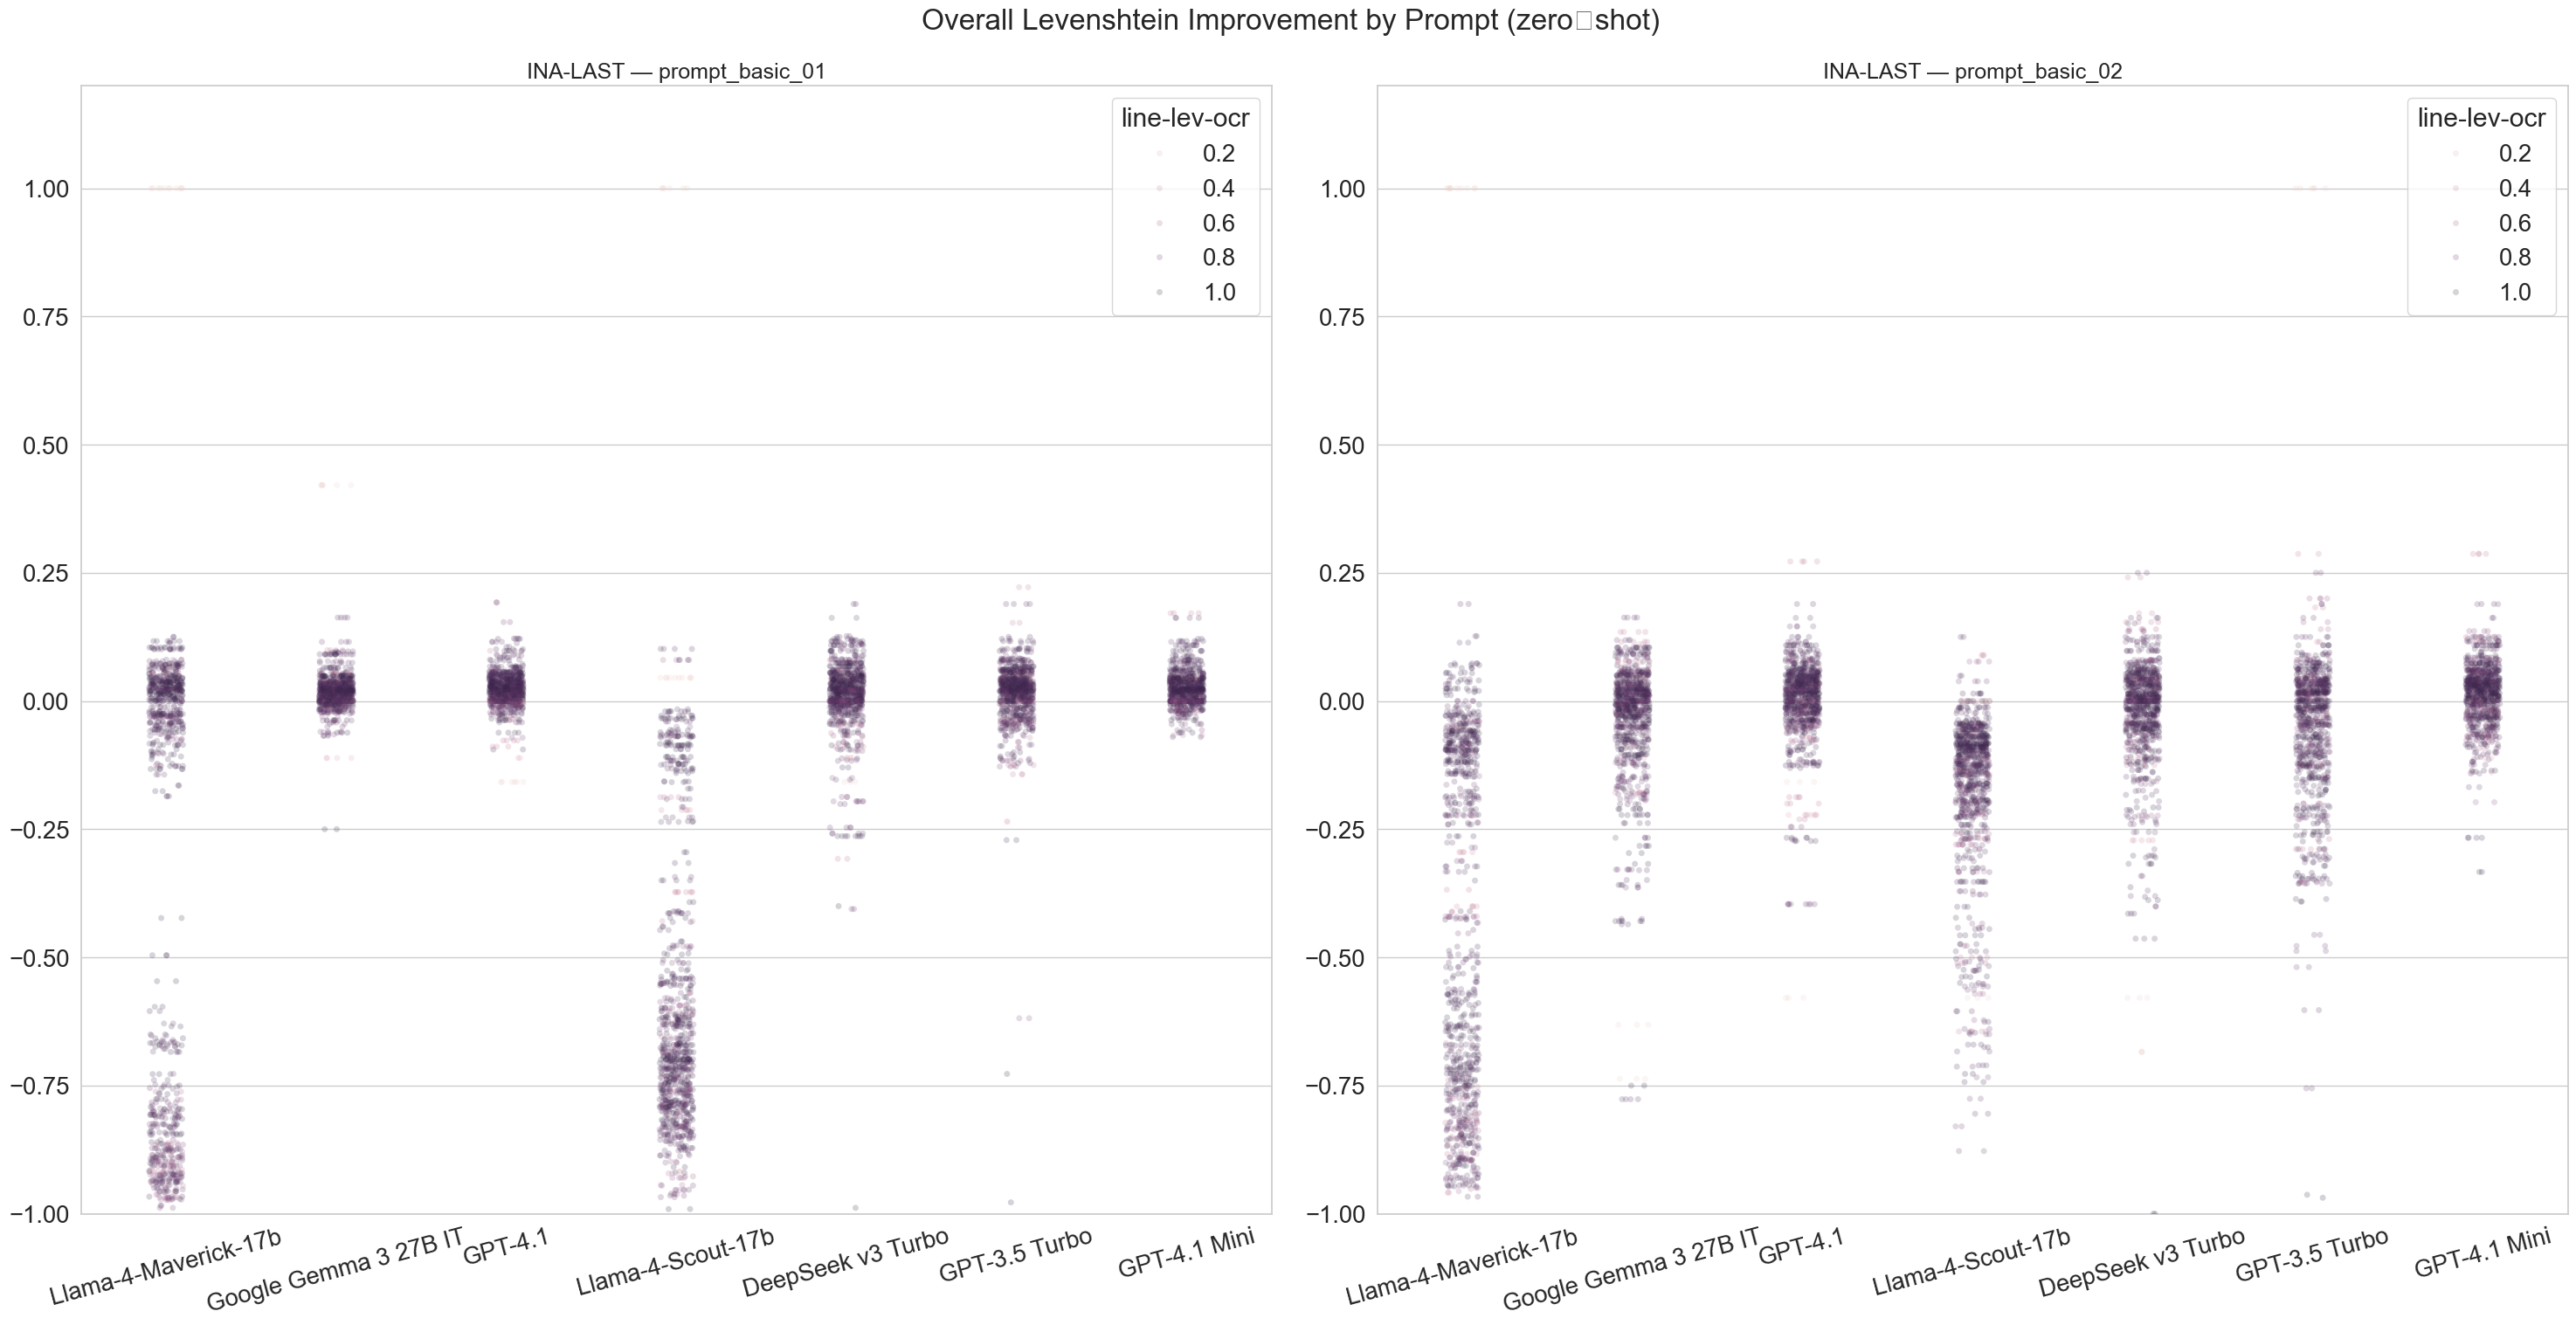

In [67]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=1.8)
sns.set_style("whitegrid")

error_rate = 'lev'

# only one dataset here
dataset = 'ina-last'

# figure out how many prompts and grid size
prompts = ['prompt_basic_01', 'prompt_basic_02']
n = len(prompts)
cols = 2
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(30, 15))
axs = axs.flatten()

for i, prompt in enumerate(prompts):
    ax = axs[i]
    # filter for this dataset, experiment & prompt
    df = data[
        (data.dataset_name == dataset)
        & (data.prompt == prompt)
    ].copy()

    # compute the overall improvement if you need to
    df['overall-levenshtein-improvement'] = df[f'line-{error_rate}-improvement']

    # draw the stripplot
    sns.stripplot(
        x='model',
        y='overall-levenshtein-improvement',
        hue='line-lev-ocr',
        data=df,
        jitter=True,
        alpha=0.2,
        size=5,
        ax=ax
    )

    ax.set_title(f'{dataset.upper()} — {prompt}', fontsize=18)
    ax.set_ylim(-1, 1.2)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=15)

    # if you don’t want a legend on every panel, remove after the first

# drop any extra panels
for j in range(n, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle(
    'Overall Levenshtein Improvement by Prompt (zero‑shot)', 
    fontsize=24, 
    y=1.02
)
plt.show()


1


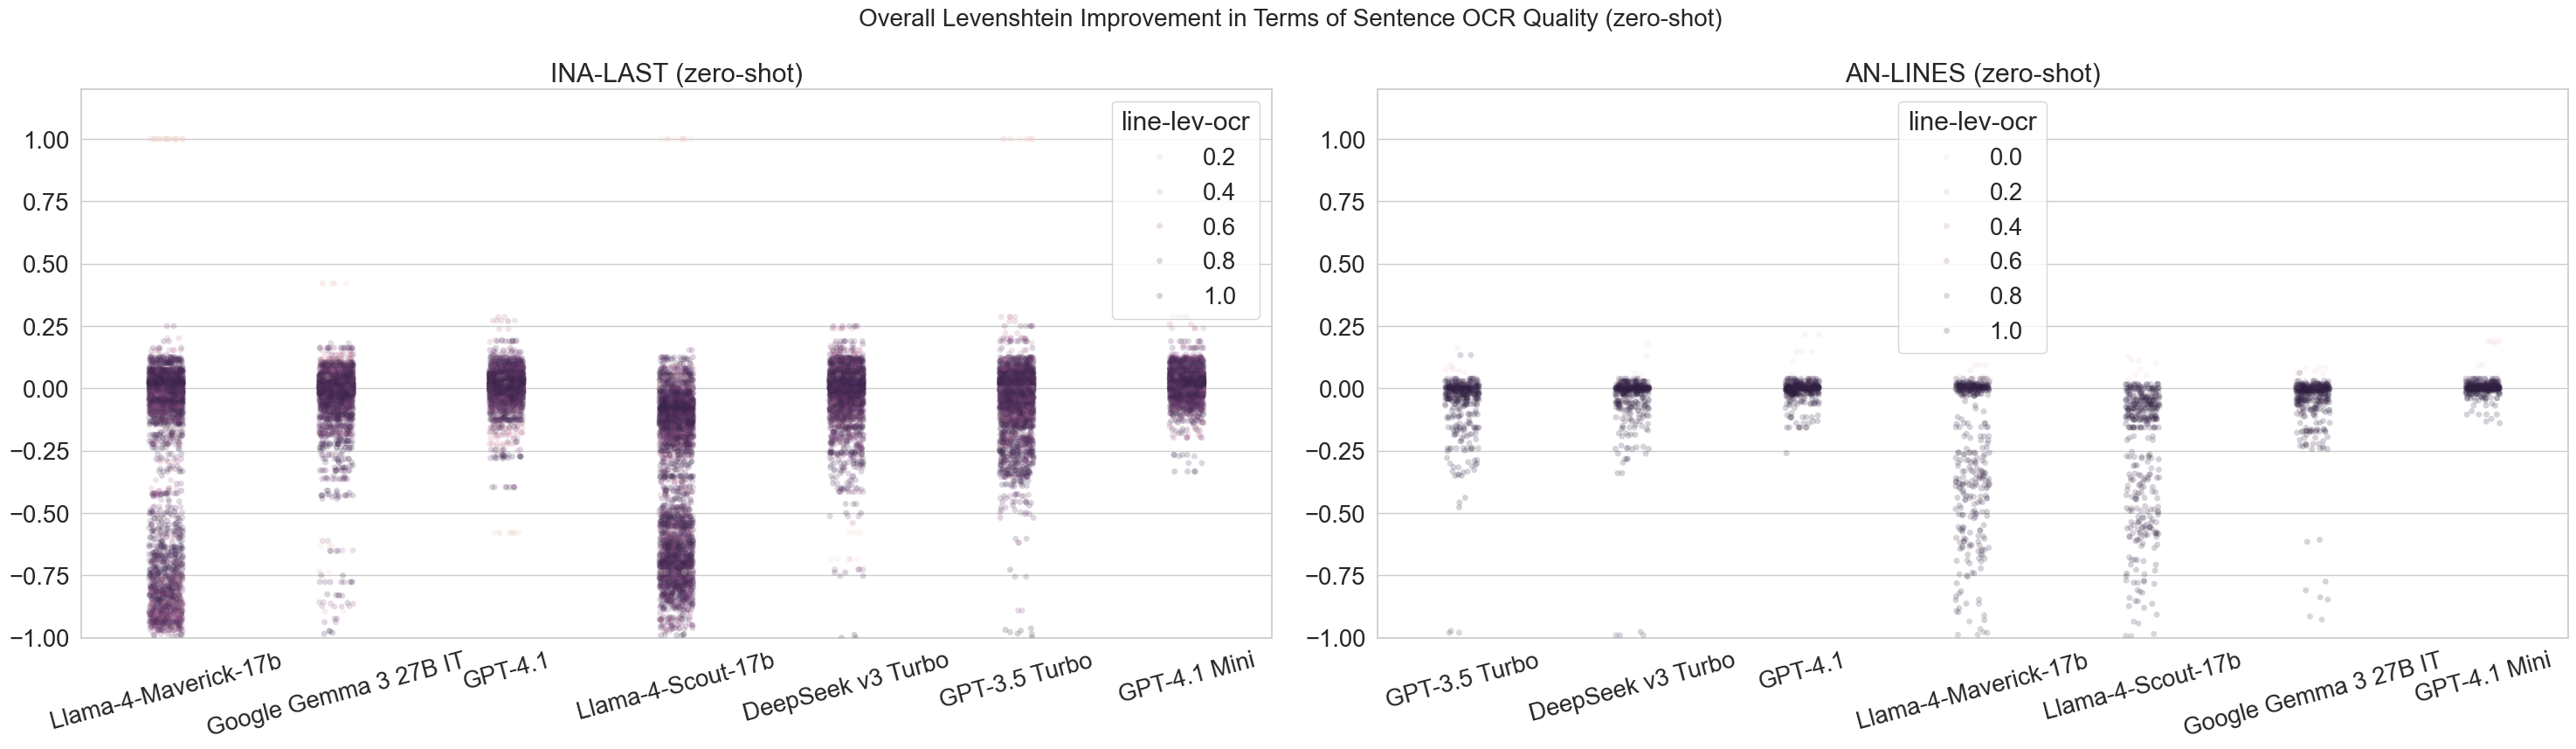

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=1.8)
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("colorblind", desat=0.6))

# Define OCR noise level bins
bins = [0, 0.4, 0.6, 0.8, 0.99, 1.0]

# Assign OCR noise level labels
labels = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]

# Count the number of unique datasets
n_datasets = data.dataset_name.nunique()
dataset_names = ['ina-last', 'AN-lines']

prompt_names = ['prompt_basic_01', 'prompt_basic_02']


n_plots = len(dataset_names)
n_plots_per_figure = 4
n_figures = int(np.ceil(n_plots / n_plots_per_figure))

print(n_figures)

for type_of_experiment in ['zero-shot']:
# for type_of_experiment in ['language-specific']:
    for error_rate in ['lev']:
        
        for fig_idx in range(n_figures):
            fig, axs = plt.subplots(2, 2, figsize=(30, 15))
            axs = axs.flatten()

            for i in range(n_plots_per_figure):
                idx = fig_idx * n_plots_per_figure + i
                if idx < n_plots:
                    dataset = dataset_names[idx]
                dataset_data = data[(data.dataset_name == dataset)]
                # Compute the mean WER across line, sentence, and region levels
#                 if 'icdar' not in dataset:
#                     dataset_data[f'overall-levenshtein-improvement'] = dataset_data[[f'line-{error_rate}-improvement', 
#                                                                       f'sentence-{error_rate}-improvement', 
#                                                                       f'region-{error_rate}-improvement']].mean(axis=1)
#                 else:
#                     dataset_data[f'overall-levenshtein-improvement'] = dataset_data[[f'sentence-{error_rate}-improvement', 
#                                                                   f'region-{error_rate}-improvement']].mean(axis=1)

                try:
                    # Plot the distribution of improvements for each model
#                     _ = sns.boxplot(x='model', y=f'sentence-lev-improvement', data=dataset_data, 
#                                     ax=axs[i], order=MODELS, hue='prompt', hue_order=prompt_names)
#                     axs[i].set_title(f'{dataset.upper()} ({type_of_experiment})')
                    
#                     # Calculate the percentage of correct OCR for this dataset
#                     correct_ocr_percentage = (dataset_data['sentence-lev-ocr'] == 1.0).mean() * 100

#                     # Add text annotation to the subplot
#                     annotation_text = f"Correct OCR: {correct_ocr_percentage:.2f}%"
#                     axs[i].annotate(annotation_text, xy=(0.05, 0.95), xycoords='axes fraction', 
#                                     fontsize=12, color='Red', va='top', ha='center')
            
                    
#                    # Plot the distribution of improvements for each model with color-coded points
#                     _ = sns.boxplot(x='model', y=f'sentence-lev-improvement', data=dataset_data, 
#                                     ax=axs[i], order=MODELS, hue='prompt', hue_order=prompt_names, 
#                                     palette='Blues' if type_of_experiment == 'zero-shot' else 'Reds')
#                     _ = sns.swarmplot(x='model', y=f'sentence-lev-improvement', data=dataset_data, 
#                                       ax=axs[i], order=MODELS, hue=f'sentence-lev-ocr', dodge=True, edgecolor='gray', linewidth=0.5)
                    _ = sns.stripplot(x='model', y=f'overall-levenshtein-improvement', hue=f'line-lev-ocr',
                                      data=dataset_data, jitter=True, alpha=0.2, ax=axs[i], size=5)

#                     print(f'{dataset.upper()} ({type_of_experiment})')
                    axs[i].set_title(f'{dataset.upper()} ({type_of_experiment})')
        
                    axs[i].set_ylim([-1, 1.2])
                    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=15)  # Rotate x-axis labels
                    axs[i].set_xlabel('')  # Remove x-axis label
                    axs[i].set_ylabel('')  # Remove y-axis label
                    
                except Exception as ex:
                    print(f'Could not load {dataset} with {ex}')

            # Remove empty subplots
            for i in range(len(data.dataset_name.unique()), len(axs)):
                fig.delaxes(axs[i])

            plt.tight_layout()
            plt.suptitle(f'Overall Levenshtein Improvement in Terms of Sentence OCR Quality ({type_of_experiment})', fontsize=20, y=1.02)
            plt.show()


In [69]:
from tqdm import tqdm

tqdm.pandas()  # <- optional: enables nice .progress_apply if you want it later
data['Accuracy_ocr'] = [
    safe_wer(gt, pred) 
    for gt, pred in tqdm(zip(data['groundtruth.line'], data['ocr.line']), total=len(data))
]

100%|██████████████████████████████████| 30228/30228 [00:00<00:00, 31128.17it/s]


In [70]:
from tqdm import tqdm

tqdm.pandas()  # <- optional: enables nice .progress_apply if you want it later
data['Accuracy_llm'] = [
    safe_wer(gt, pred) 
    for gt, pred in tqdm(zip(data['groundtruth.line'], data['prediction.line']), total=len(data))
]

100%|██████████████████████████████████| 30228/30228 [00:00<00:00, 31823.51it/s]


In [72]:
data['acc_diff'] = data['Accuracy_llm'] - data['Accuracy_ocr']


ValueError: zero-size array to reduction operation fmin which has no identity

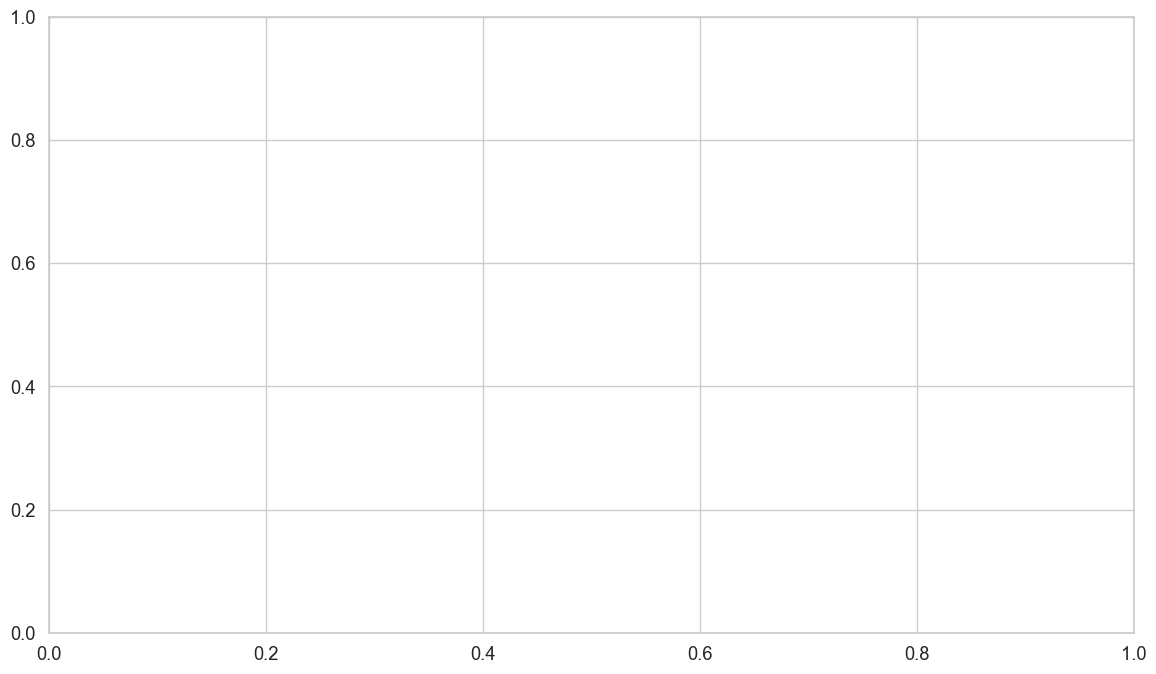

In [79]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from matplotlib.colors import TwoSlopeNorm

# --- préparation de l'output ---
output_dir = "../data/wer1"
os.makedirs(output_dir, exist_ok=True)

# --- filtrage du modèle ---
data2 = data[data['model'] == 'gpt-4.1-mini']

# --- pivot pour avoir en index (dataset, temp) et en colonnes les prompts ---
heat = (
    data2
    .groupby(['dataset_name', 'temperature', 'prompt'])['Wer_improvement']
    .mean()
    .unstack('prompt')   # chaque prompt devient une colonne
)

# --- transpose pour inverser les axes (prompts ↔ (dataset, temp))---
heat_t = heat.T

# --- style seaborn ---
sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# --- normalisation bicolore autour de zéro ---
vmin, vcenter, vmax = -0.5, 0, 0.5
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# --- tracé de la heatmap inversée ---
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(
    heat_t,
    annot=True, fmt=".2f",
    cmap="RdYlGn",
    norm=norm,
    cbar_kws={
        "label": "Avg post-proc line-lev Improvement",
        "ticks": np.linspace(vmin, vmax, 7)
    },
    ax=ax
)

# --- reformatage des labels d'abscisse (x) pour afficher dataset + temp ---
xticks = [f"{ds}\n{temp:.2f}" for ds, temp in heat.index]
ax.xaxis.set_major_locator(FixedLocator(np.arange(len(xticks)) + 0.5))
ax.set_xticklabels(xticks, rotation=0, ha='center')

# --- reformatage des labels d'ordonnée (y) pour afficher les prompts ---
ax.set_yticklabels(heat_t.index, rotation=0, va='center')

# --- labels et titre (axes échangés) ---
ax.set_xlabel("Dataset  Temperature")
ax.set_ylabel("Prompt")
ax.set_title(None)

plt.tight_layout()

# --- enregistrement ---
filepath = os.path.join(output_dir, "heatmap_wer_improvement.png")
fig.savefig(filepath, dpi=300, bbox_inches='tight')
print(f"Saved: {filepath}")

plt.show()


Saved: ../data/heatmaps1/heatmap_prompt_basic_01.png


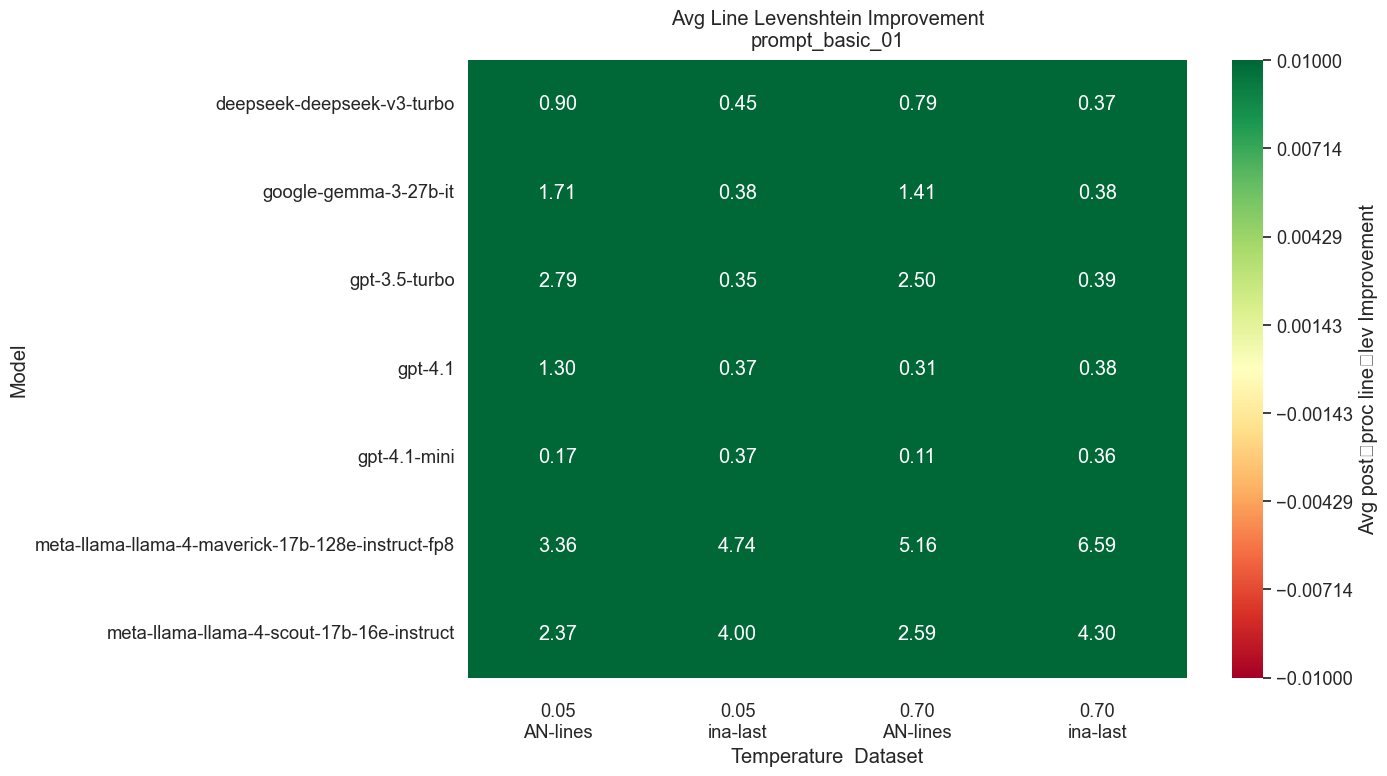

Saved: ../data/heatmaps1/heatmap_prompt_basic_02.png


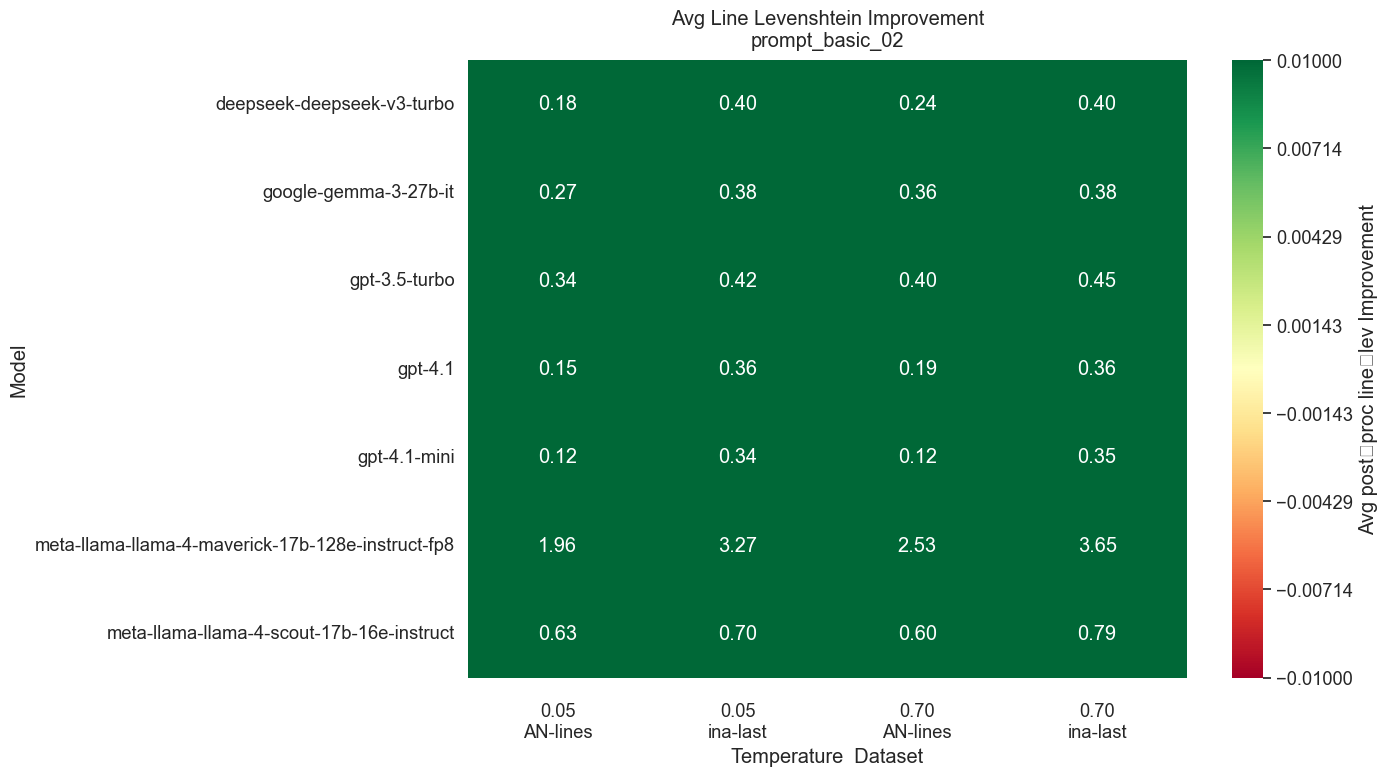

Saved: ../data/heatmaps1/heatmap_prompt_complex_01.png


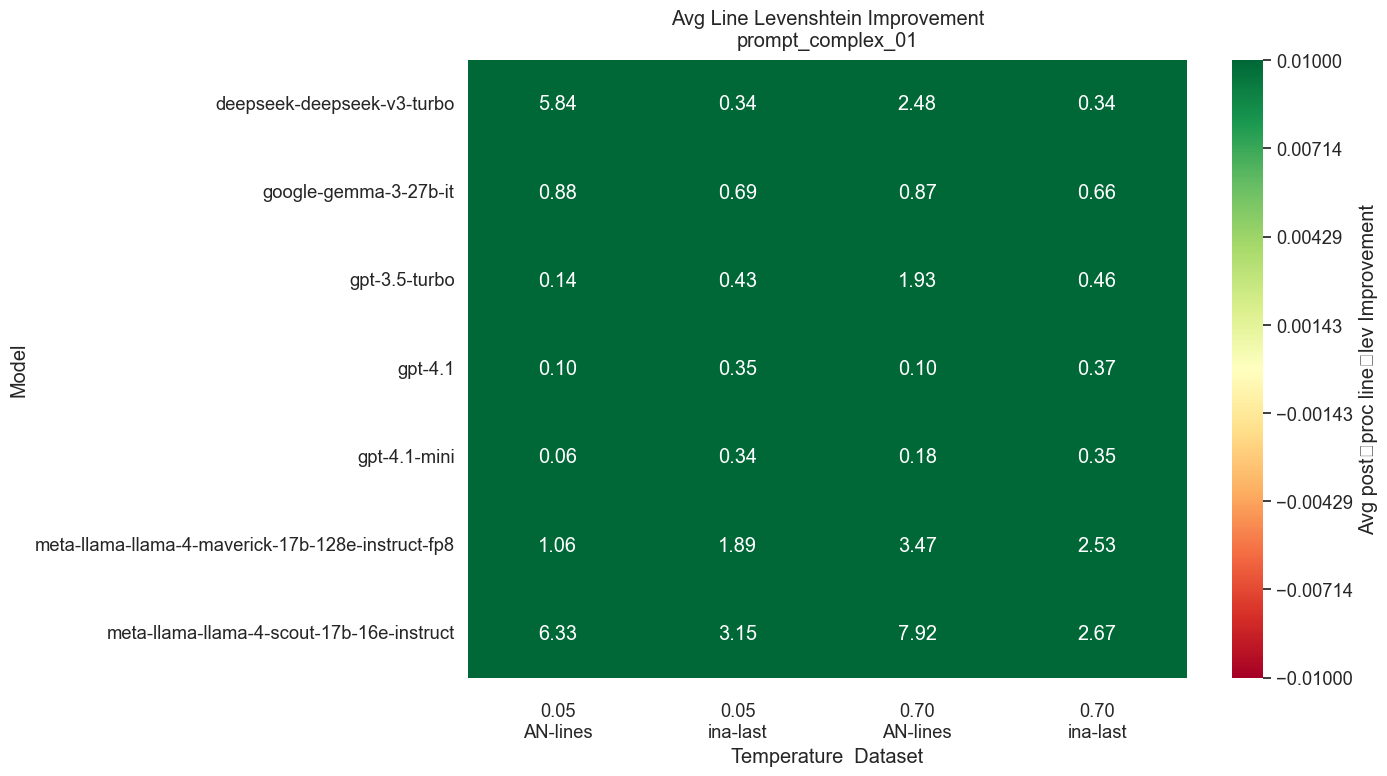

Saved: ../data/heatmaps1/heatmap_prompt_complex_02.png


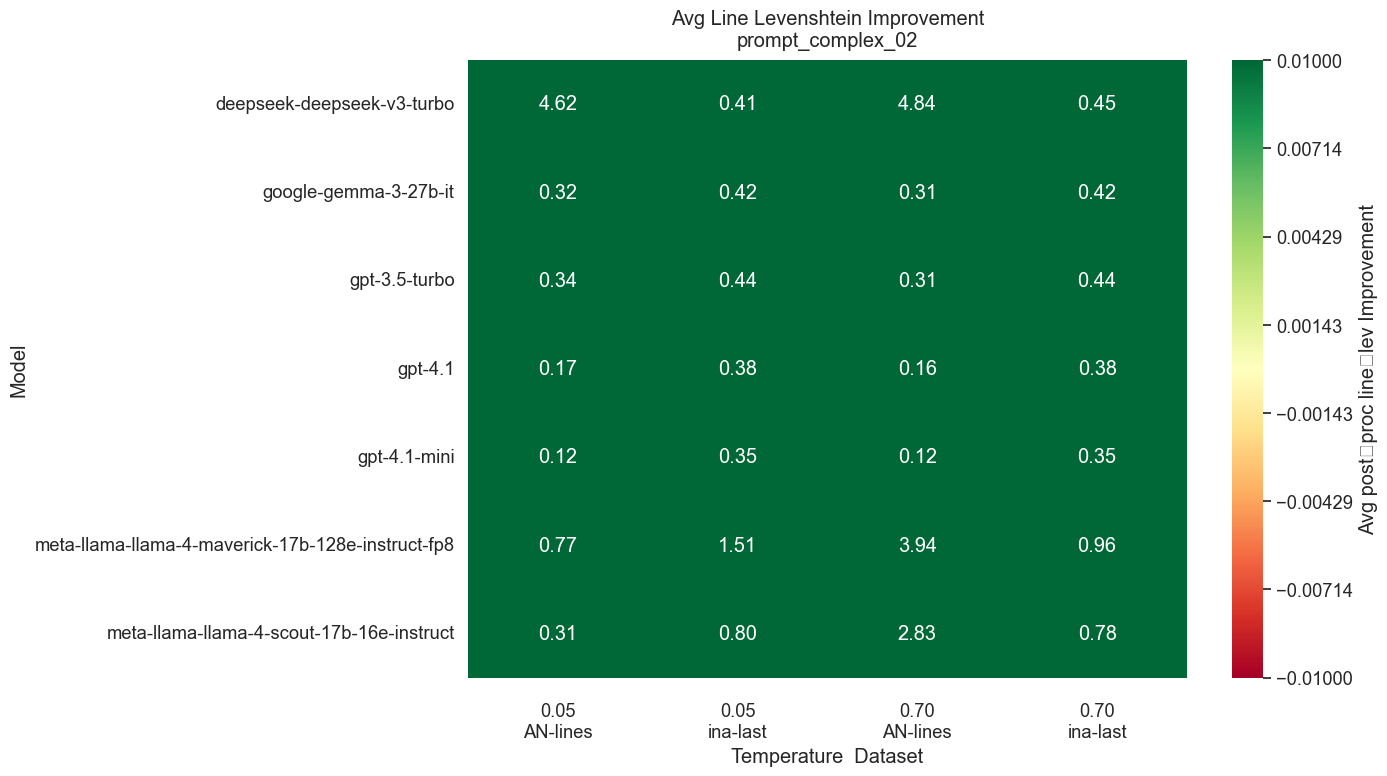

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from matplotlib.colors import TwoSlopeNorm
import os

# --- Chargez votre DataFrame `data` avant tout ---
# ex. : data = pd.read_csv('votre_fichier.csv')

# Créez un dossier pour y stocker les images
output_dir = "../data/heatmaps1"
os.makedirs(output_dir, exist_ok=True)

# Configuration Seaborn
sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Norme à deux slopes : centre à 0, étirement positif plus serré
vmin, vcenter, vmax = -0.01, 0, 0.01
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

prompt_list = sorted(data['prompt'].unique().tolist())

for prompt in prompt_list:
    # 1) pivot
    heat = (
        data[data['prompt'] == prompt]
            .groupby(['model','dataset_name','temperature'])['Accuracy_llm']
            .mean()
            .unstack(['dataset_name','temperature'])
    )

    # 2) swap & sort : temperature en level 0, dataset en level 1
    heat = heat.swaplevel('dataset_name', 'temperature', axis=1)
    heat = heat.sort_index(axis=1, level=[0, 1])

    # 3) heatmap avec TwoSlopeNorm
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.heatmap(
        heat,
        annot=True, fmt=".2f",
        cmap="RdYlGn",
        norm=norm,
        cbar_kws={
            "label": "Avg post‑proc line‑lev Improvement",
            "ticks": np.linspace(vmin, vmax, 8)
        },
        ax=ax
    )

    # 4) custom xticks centrés et plus bas
    labels = [f"{temp:.2f}\n{ds}" for temp, ds in heat.columns]
    pos    = np.arange(len(labels)) + 0.5
    ax.xaxis.set_major_locator(FixedLocator(pos))
    ax.set_xticklabels(
        labels,
        rotation=0,
        ha='center',
        va='top'
    )
    ax.tick_params(axis='x', pad=12)

    # 5) labels et titre
    ax.set_xlabel("Temperature  Dataset")
    ax.set_ylabel("Model")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(
        f"Avg Line Levenshtein Improvement\n{prompt}",
        pad=10
    )

    plt.tight_layout()

    # --- ENREGISTREMENT ---
    filename = f"heatmap_{prompt.replace(' ', '_')}.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")

    plt.show()


Saved: ../data/heatmaps_/heatmap_prompt_basic_01.png


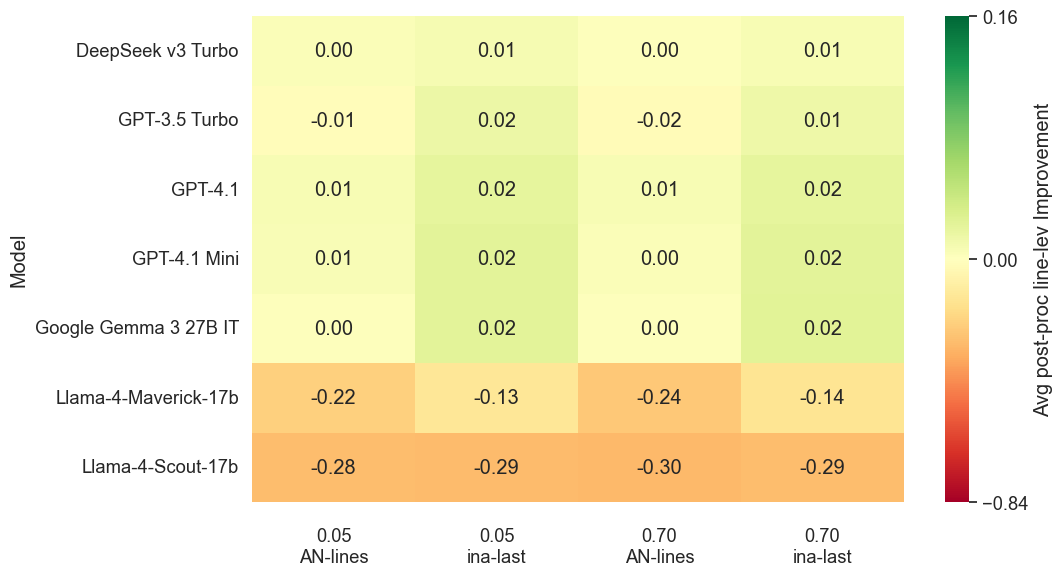

Saved: ../data/heatmaps_/heatmap_prompt_basic_02.png


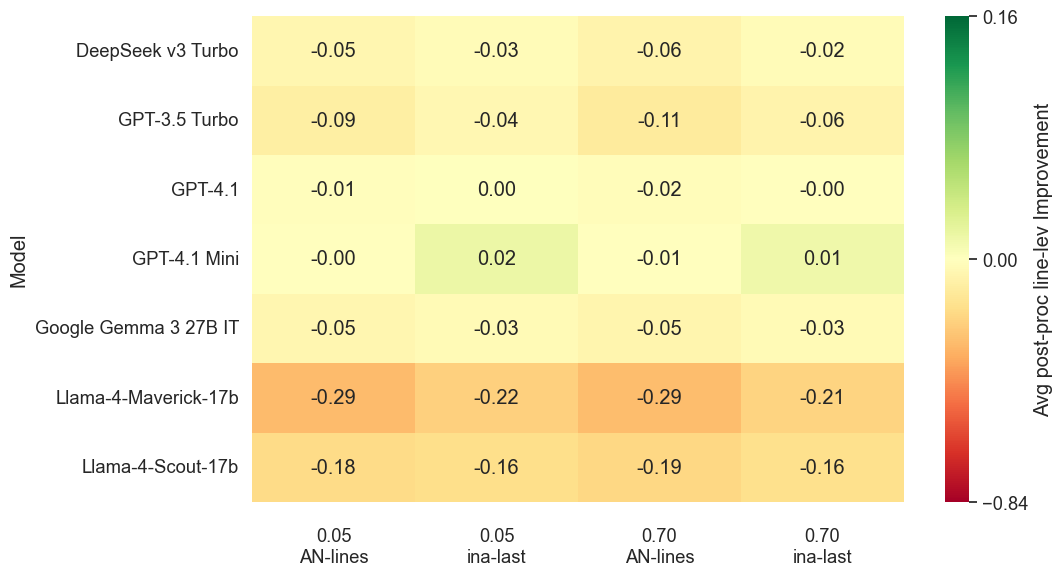

Saved: ../data/heatmaps_/heatmap_prompt_complex_01.png


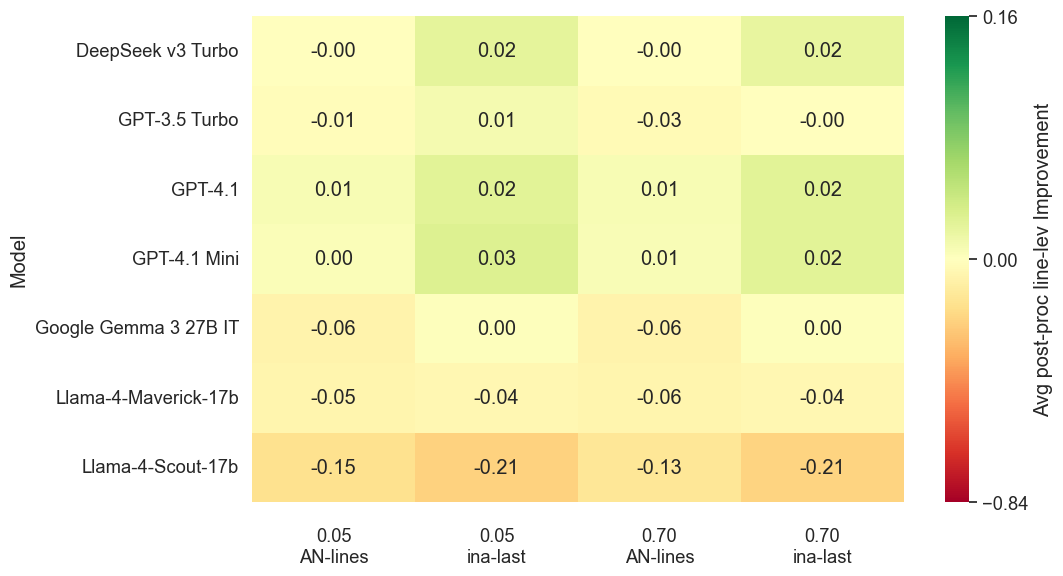

Saved: ../data/heatmaps_/heatmap_prompt_complex_02.png


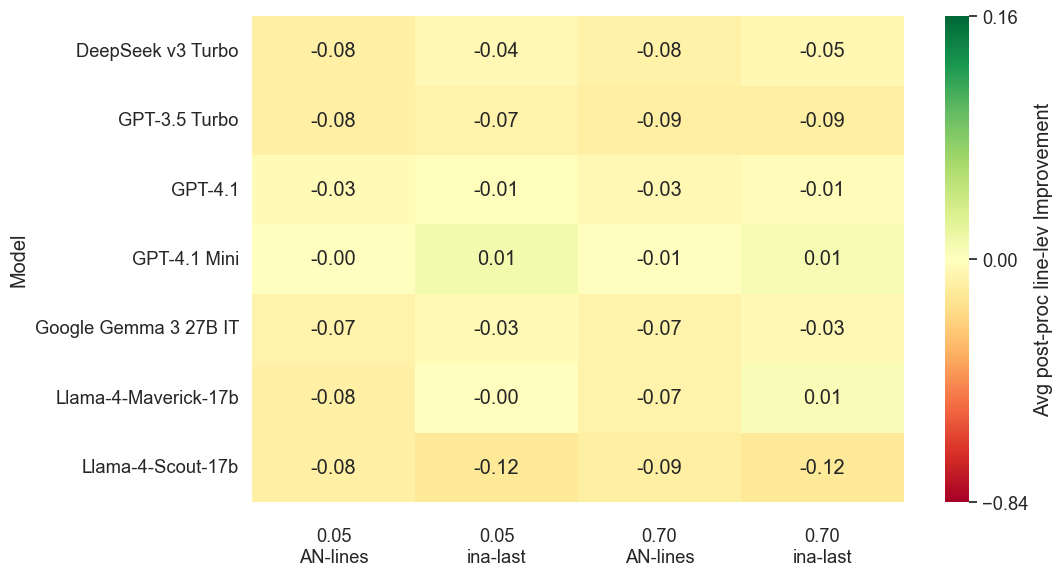

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from matplotlib.colors import TwoSlopeNorm
import os

# --- Chargez votre DataFrame `data` avant tout ---
# ex. : data = pd.read_csv('votre_fichier.csv')

# Créez un dossier pour y stocker les images
output_dir = "../data/heatmaps_"
os.makedirs(output_dir, exist_ok=True)

# Configuration Seaborn
sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Norme à deux slopes : centre à 0, étirement positif plus serré
vmin, vcenter, vmax = -0.84, 0.0, 0.16
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

prompt_list = sorted(data['prompt'].unique().tolist())

for prompt in prompt_list:
    # 1) pivot
    heat = (
        data[data['prompt'] == prompt]
            .groupby(['model','dataset_name','temperature'])['line-lev-improvement-postprocessed']
            .mean()
            .unstack(['dataset_name','temperature'])
    )

    # 2) swap & sort : temperature en level 0, dataset en level 1
    heat = heat.swaplevel('dataset_name', 'temperature', axis=1)
    heat = heat.sort_index(axis=1, level=[0, 1])

    # 3) heatmap avec TwoSlopeNorm
    fig, ax = plt.subplots(figsize=(11, 6))
    sns.heatmap(
        heat,
        annot=True, fmt=".2f",
        cmap="RdYlGn",
        norm=norm,
        cbar_kws={
            "label": "Avg post-proc line-lev Improvement",
            "ticks": [vmin, vcenter, vmax]   
        },
        ax=ax
    )

    # 4) custom xticks centrés et plus bas
    labels = [f"{temp:.2f}\n{ds}" for temp, ds in heat.columns]
    pos    = np.arange(len(labels)) + 0.5
    ax.xaxis.set_major_locator(FixedLocator(pos))
    ax.set_xticklabels(
        labels,
        rotation=0,
        ha='center',
        va='top'
    )
    ax.tick_params(axis='x', pad=12)

    # 5) labels et titre
    ax.set_xlabel(None)
    plt.xticks(rotation=0)
    ax.set_ylabel("Model")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()

    # --- ENREGISTREMENT ---
    filename = f"heatmap_{prompt.replace(' ', '_')}.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")

    plt.show()


In [80]:
# Calculate the percentage of each improvement band for each unique model
improvement_percentage_by_model = data.groupby('model')['improvement-band'].value_counts(normalize=True).unstack() * 100


In [81]:
improvement_percentage_by_model

improvement-band,Negative Improvement,No Improvement,Positive Improvement
model,,,
DeepSeek v3 Turbo,39.717462,7.040296,53.242242
GPT-3.5 Turbo,45.913406,4.700162,49.386432
GPT-4.1,29.620195,7.781380,62.598425
GPT-4.1 Mini,24.542718,9.307710,66.149572
Google Gemma 3 27B IT,39.198889,7.524890,53.276221
Llama-4-Maverick-17b,57.331480,2.177438,40.491082
Llama-4-Scout-17b,91.384900,1.227420,7.387679


In [82]:
table = data.groupby(['model', 'improvement-band']).size().unstack(fill_value=0)

table.to_csv('improvement_band_distribution_by_model.csv')

latex_table = improvement_percentage_by_model.to_latex()
print(latex_table)

\begin{tabular}{lrrr}
\toprule
improvement-band & Negative Improvement & No Improvement & Positive Improvement \\
model &  &  &  \\
\midrule
DeepSeek v3 Turbo & 39.717462 & 7.040296 & 53.242242 \\
GPT-3.5 Turbo & 45.913406 & 4.700162 & 49.386432 \\
GPT-4.1 & 29.620195 & 7.781380 & 62.598425 \\
GPT-4.1 Mini & 24.542718 & 9.307710 & 66.149572 \\
Google Gemma 3 27B IT & 39.198889 & 7.524890 & 53.276221 \\
Llama-4-Maverick-17b & 57.331480 & 2.177438 & 40.491082 \\
Llama-4-Scout-17b & 91.384900 & 1.227420 & 7.387679 \\
\bottomrule
\end{tabular}



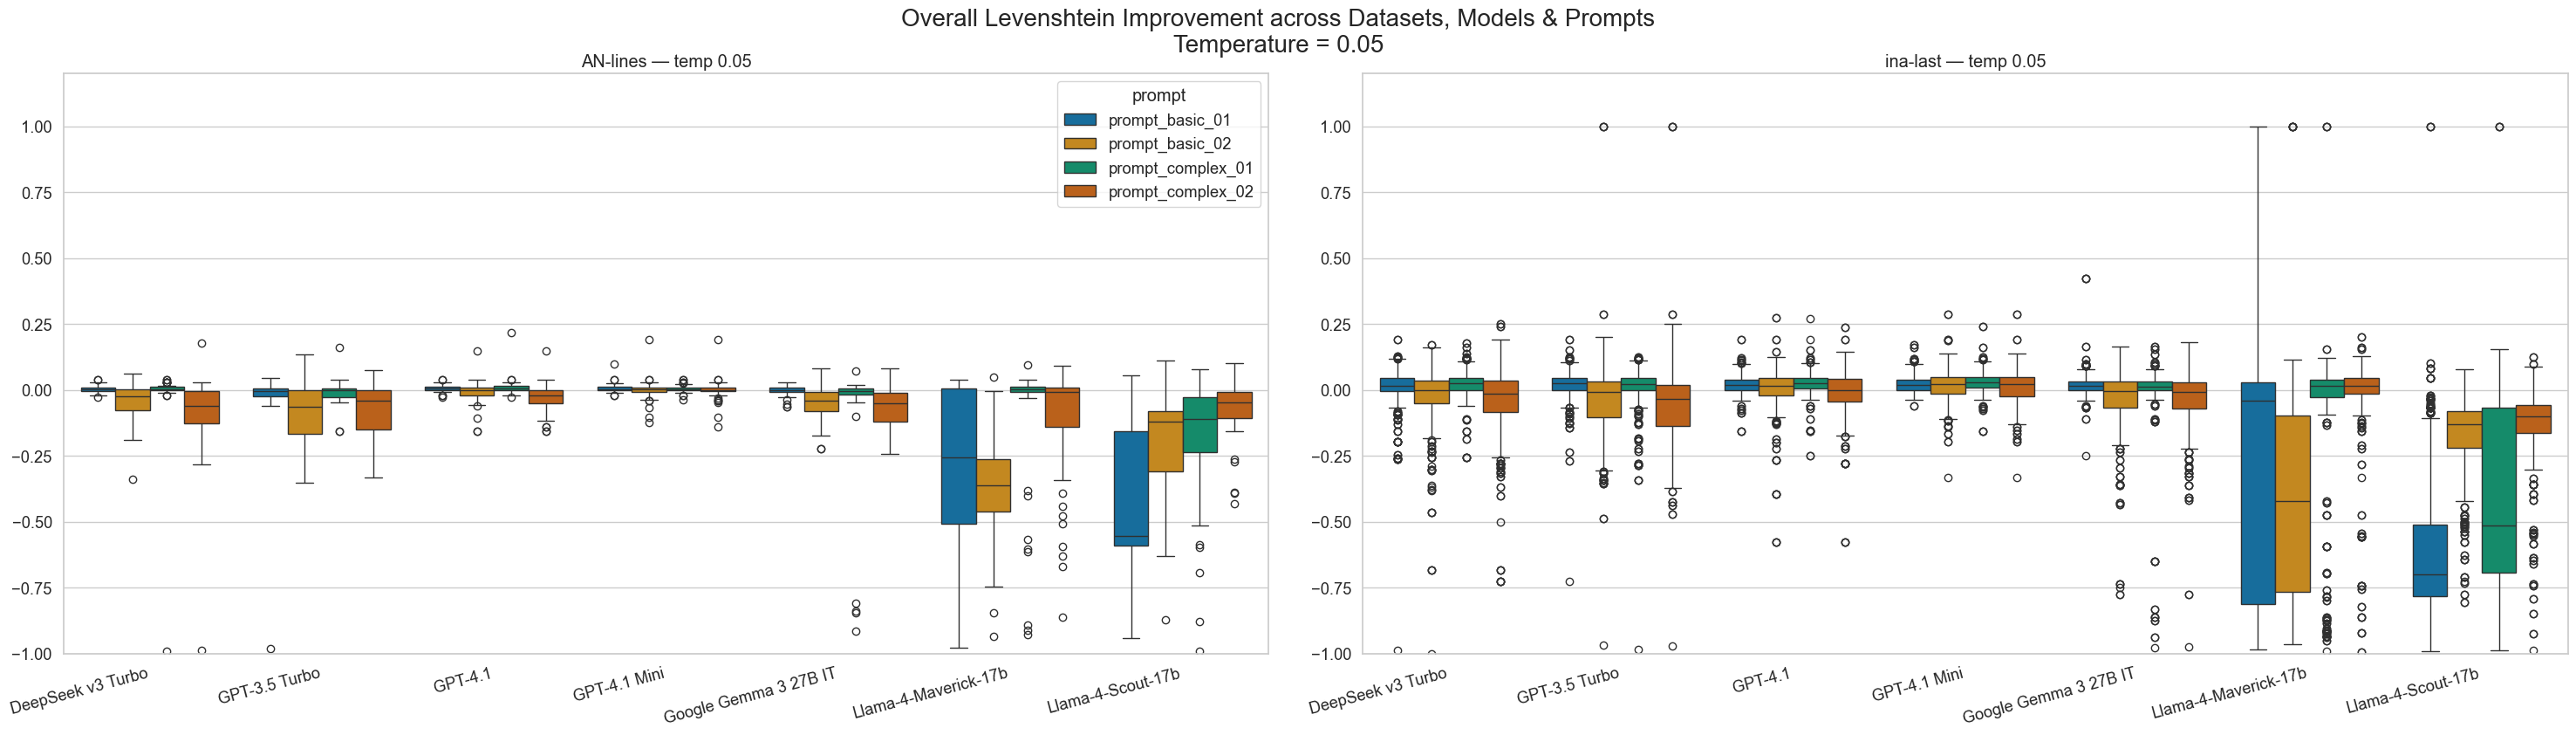

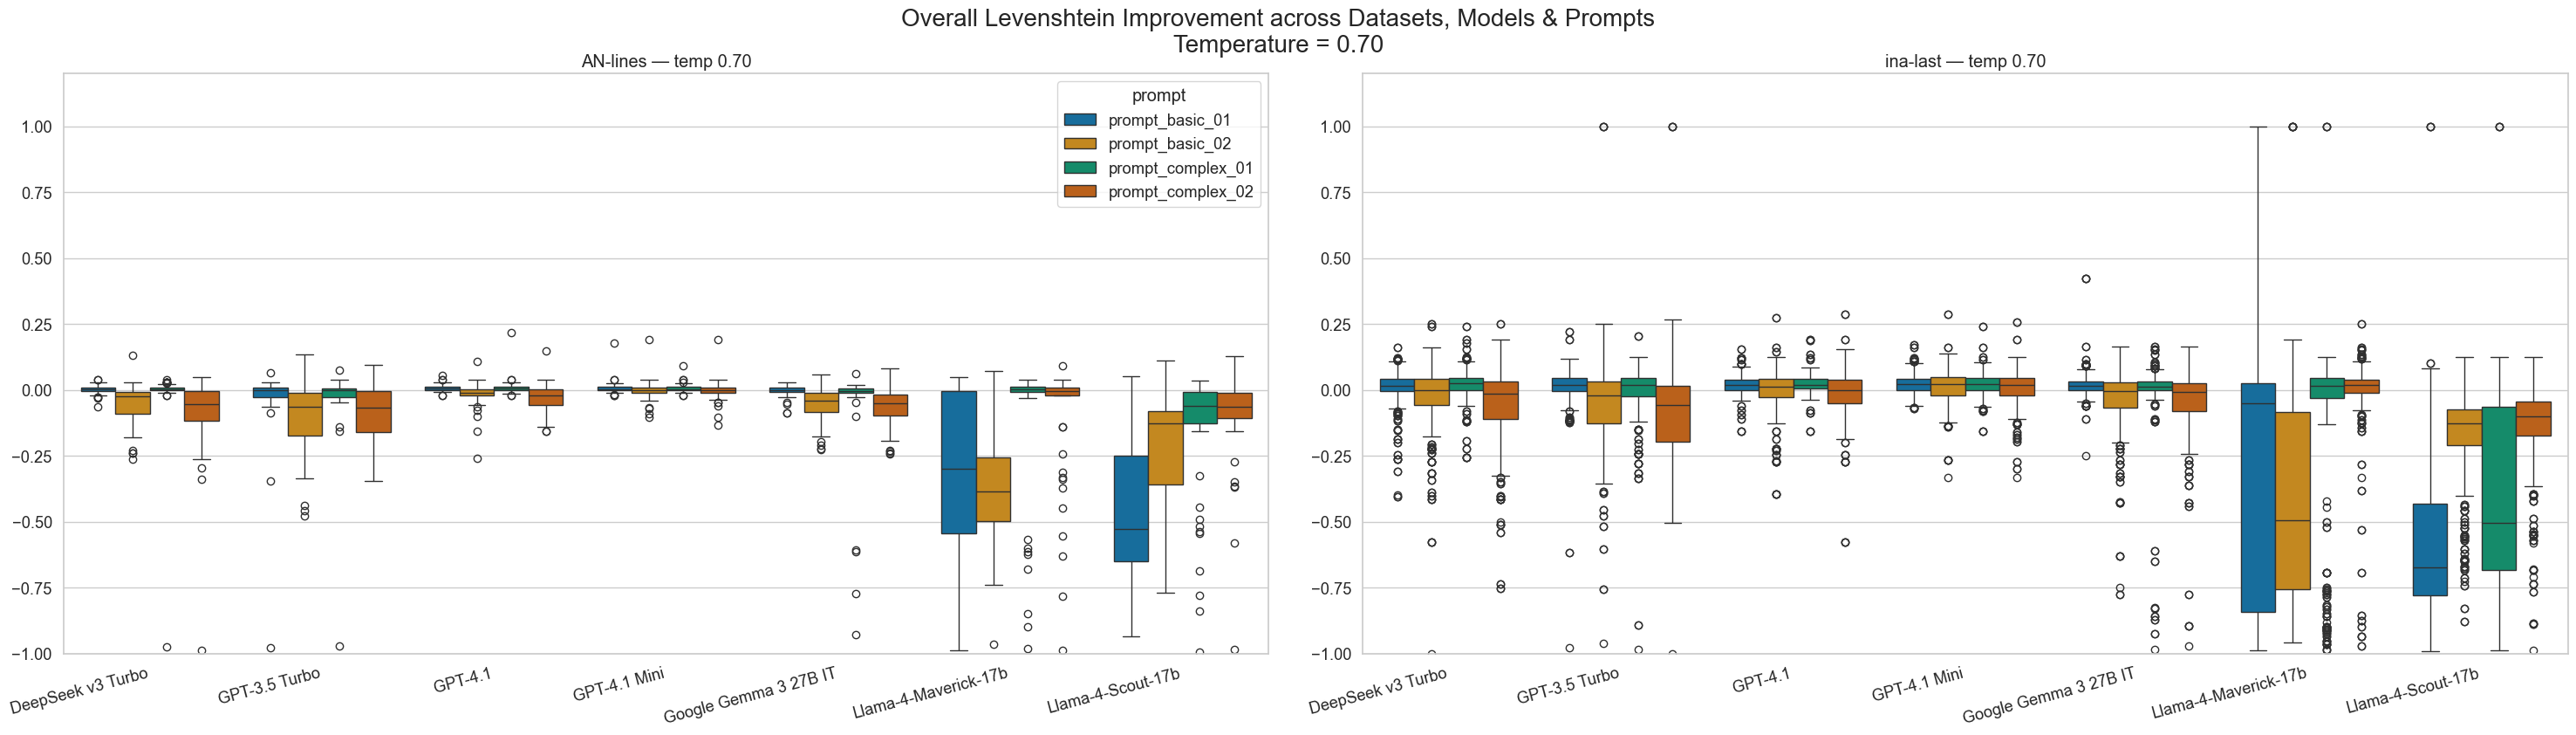

In [83]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# pull your true dataset names from the DataFrame
dataset_names = sorted(data['dataset_name'].unique().tolist())

# your prompts (still used for the hue)
prompt_names = [
    'prompt_basic_01', 'prompt_basic_02',
    'prompt_complex_01', 'prompt_complex_02'
]

# models ordering
MODELS = sorted(data['model'].unique().tolist())

# only one error‐rate here
error_rate = 'lev'

# how many panels per figure (2×2 grid)
per_fig = 4
n_plots  = len(dataset_names)
n_figs   = math.ceil(n_plots / per_fig)

# outer loop over each temperature
for temp in sorted(data['temperature'].unique()):
    for fig_idx in range(n_figs):
        fig, axes = plt.subplots(2, 2, figsize=(30, 15))
        axes = axes.flatten()

        # slice out up to 4 datasets for this figure
        slice_ds = dataset_names[fig_idx*per_fig : (fig_idx+1)*per_fig]

        for ax, ds in zip(axes, slice_ds):
            # filter both on dataset *and* temperature
            df = data[
                (data['dataset_name'] == ds) &
                (data['temperature']  == temp)
            ].copy()

            if df.empty:
                ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=16)
                ax.set_title(f"{ds} — temp {temp:.2f}")
                ax.axis('off')
                continue

            # compute your overall improvement if not already done
            df['overall-levenshtein-improvement'] = df[f'line-{error_rate}-improvement']

            # draw the boxplot
            sns.boxplot(
                x='model',
                y='overall-levenshtein-improvement',
                hue='prompt',
                hue_order=prompt_names,
                order=MODELS,
                data=df,
                ax=ax
            )
            ax.set_title(f"{ds} — temp {temp:.2f}")
            ax.set_ylim(-1, 1.2)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
            ax.set_xlabel('')
            ax.set_ylabel('')

            # only keep the legend on the first subplot of the first figure
            if not (fig_idx == 0 and ax is axes[0]):
                lg = ax.get_legend()
                if lg:
                    lg.remove()

        # hide any unused axes
        for extra_ax in axes[len(slice_ds):]:
            extra_ax.set_visible(False)

        plt.tight_layout()
        fig.suptitle(
            f"Overall Levenshtein Improvement across Datasets, Models & Prompts\n"
            f"Temperature = {temp:.2f}",
            fontsize=20,
            y=1.02
        )
        plt.show()


'prompt_basic_01': 7556 rows, improvement range = -0.9908814589665653 to 1.0
'prompt_basic_02': 7558 rows, improvement range = -1.0 to 1.0
'prompt_complex_01': 7556 rows, improvement range = -0.9934940681209338 to 1.0
'prompt_complex_02': 7558 rows, improvement range = -1.0 to 1.0


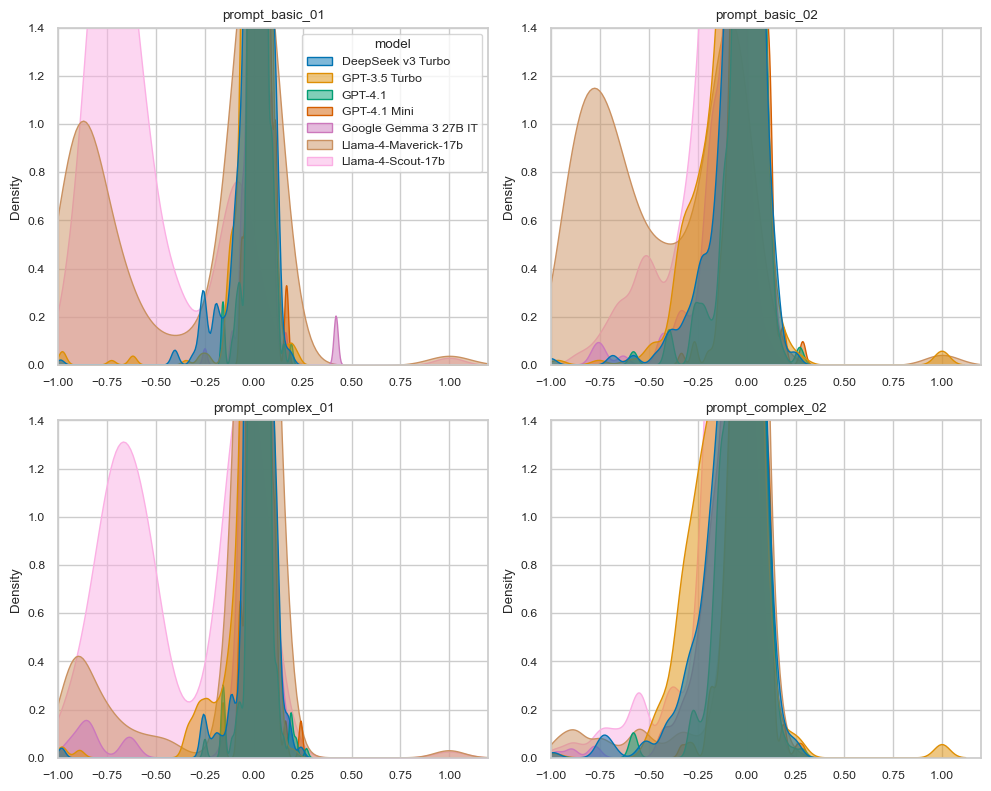

In [84]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

# styling
sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=0.8)
sns.set_style("whitegrid")

# pull the four prompts from your DataFrame
prompt_names = sorted(data['prompt'].unique().tolist())
# pull whatever models you have
MODELS = sorted(data['model'].unique().tolist())

n = len(prompt_names)           # should be 4
cols = 2
rows = math.ceil(n / cols)      # will be 2

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axs = axs.flatten()

for i, prompt in enumerate(prompt_names):
    ax = axs[i]
    sub = data[data['prompt'] == prompt].copy()
    
    # if this slice is empty, just label it and skip
    if sub.empty:
        ax.text(0.5, 0.5, "No data", ha='center', va='center')
        ax.set_title(prompt)
        ax.axis('off')
        continue

    # sanity‐check: how many rows & what range?
    print(f"{prompt!r}: {len(sub)} rows, improvement range =",
          sub['overall-levenshtein-improvement'].min(),
          "to", sub['overall-levenshtein-improvement'].max())

    # draw the KDE
    sns.kdeplot(
        data=sub,
        x='overall-levenshtein-improvement',
        hue='model',
        hue_order=MODELS,
        fill=True,
        common_norm=False,   # scale each distro independently
        alpha=0.5,
        ax=ax
    )

    ax.set_title(prompt)
    ax.set_xlim(-1, 1.2)
    ax.set_ylim(0, 1.4)
    ax.set_xlabel("")
    ax.set_ylabel("Density")

    # only show one legend
    if i > 0 and ax.get_legend() is not None:
        ax.get_legend().remove()

# hide any extra axes (in case n < rows*cols)
for j in range(n, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.show()


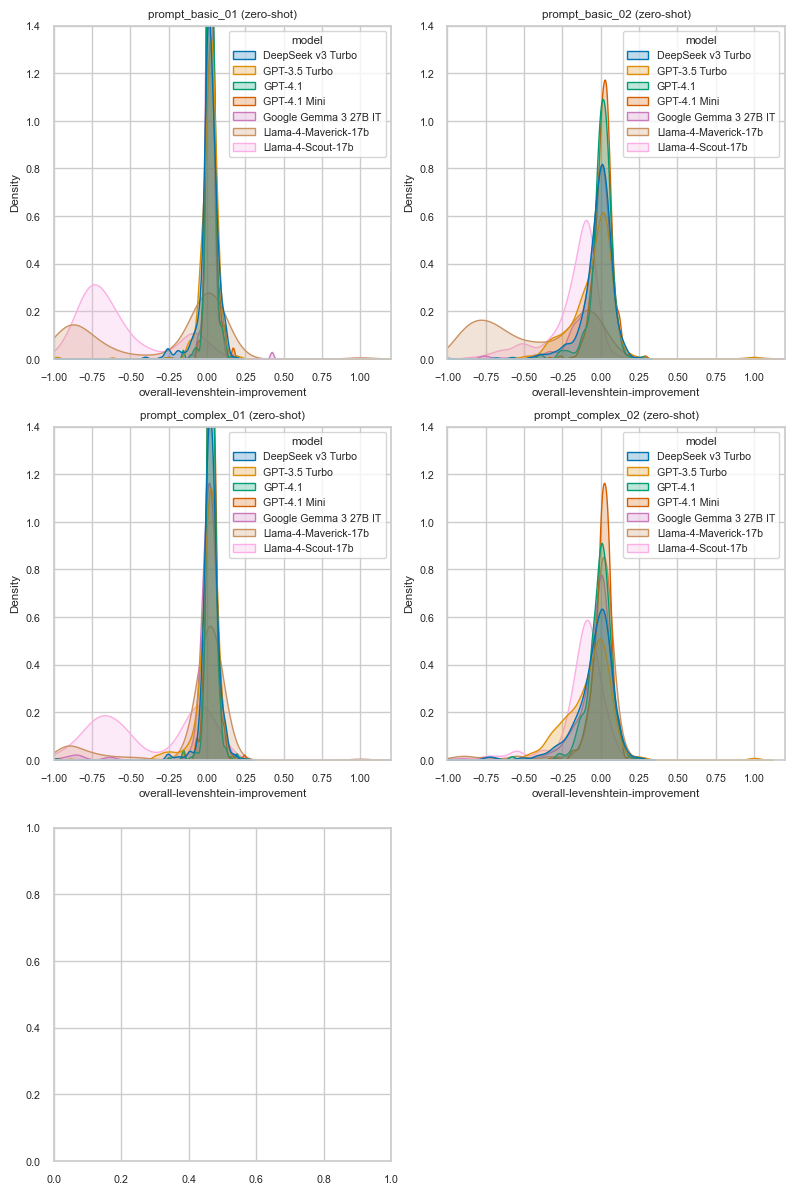

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=.7)
sns.set_style("whitegrid")

for type_of_experiment in ['zero-shot']:
    for error_rate in ['lev']:
        fig, axs = plt.subplots(3, 2, figsize=(8, 12))  # Change here
        axs = axs.flatten()  # To make it easy to index

        for i, prompt in enumerate(prompt_names):
            prompt_data = data[(data.prompt == prompt)]
            

            prompt_data['overall-levenshtein-improvement'] = prompt_data[[f'line-{error_rate}-improvement']].mean(axis=1)

            try:
                if len(prompt_data) > 0:
                    sns.kdeplot(data=prompt_data, x='overall-levenshtein-improvement', hue='model', 
                                fill=True, ax=axs[i], hue_order=MODELS)
                    axs[i].set_title(f'{prompt} ({type_of_experiment})')
                    axs[i].set_xlim([-1, 1.2])
                    axs[i].set_ylim([0, 1.4])
            except Exception as ex:
                print(f'Could not plot {prompt} with {ex}')

        # Remove empty subplot
        fig.delaxes(axs[-1])  # Change here

        plt.tight_layout()
        plt.show()
        
# A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, 
# analogous to a histogram. KDE represents the data using a continuous probability density curve in one or more 
# dimensions.

# Relative to a histogram, KDE can produce a plot that is less cluttered and more interpretable, especially when 
# drawing multiple distributions. But it has the potential to introduce distortions if the underlying distribution 
# is bounded or not smooth. Like a histogram, the quality of the representation also depends on the selection of 
# good smoothing parameters.


In [86]:
data.columns

Index(['filename', 'language', 'dataset_name', 'ocr.line', 'ocr.sentence',
       'groundtruth.line', 'groundtruth.sentence', 'prediction.line', 'model',
       'prompt', 'prompt_text', 'file', 'name_of_file_idx',
       'prediction.line.postprocessed', 'post-processings', 'line-lev-ocr',
       'line-lev-pred', 'line-lev-improvement', 'quality-band-line',
       'line-lev-pred-postprocessed', 'line-lev-improvement-postprocessed',
       'overall-levenshtein-improvement',
       'overall-levenshtein-improvement-postprocessed', 'overall-lev-ocr',
       'improvement-band', 'prediction.sentence', 'temperature',
       'Quality Band', 'Access', 'Accuracy_ocr', 'Accuracy_llm', 'acc_diff',
       'Wer_improvement'],
      dtype='object')

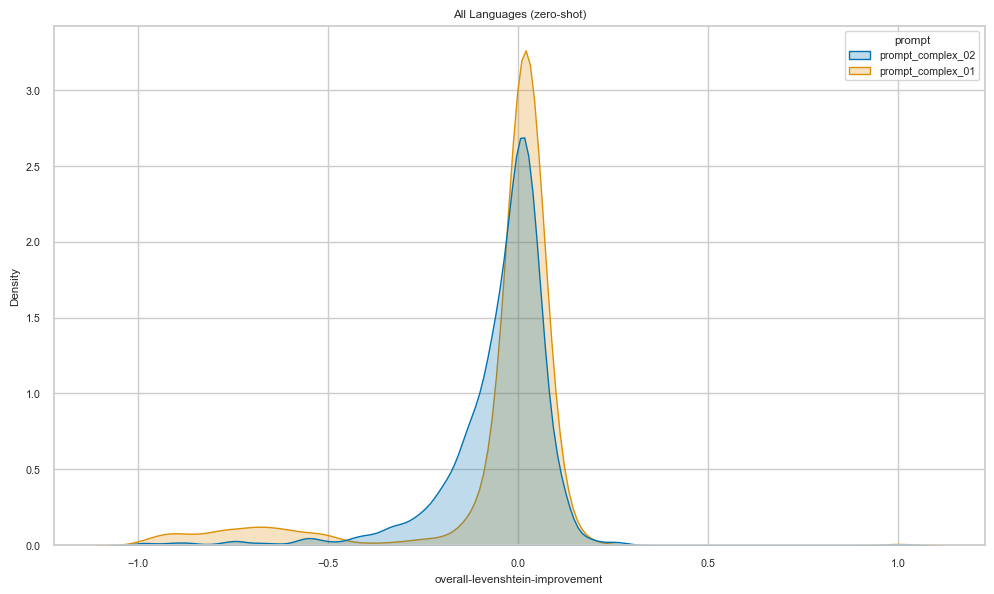

In [87]:
prompts_to_compare = ['prompt_complex_02', 'prompt_complex_01']
languages = [lang for lang in data['language'].unique() if lang != 'en']  # Exclude 'en' language

for type_of_experiment in ['zero-shot']:
    for error_rate in ['lev']:
        plt.figure(figsize=(10, 6))  # Adjust as necessary

        for language in languages:
            language_data = data[(data.language == language) & 
                                 (data.prompt.isin(prompts_to_compare))]


            language_data['overall-levenshtein-improvement'] = language_data[[f'line-{error_rate}-improvement']] 

            try:
                if len(language_data) > 0:
                    sns.kdeplot(data=language_data, x='overall-levenshtein-improvement', hue='prompt', 
                                fill=True, hue_order=prompts_to_compare)
            except Exception as ex:
                print(f'Could not plot {language} with {ex}')

        plt.title(f'All Languages ({type_of_experiment})')
        plt.tight_layout()
        plt.show()


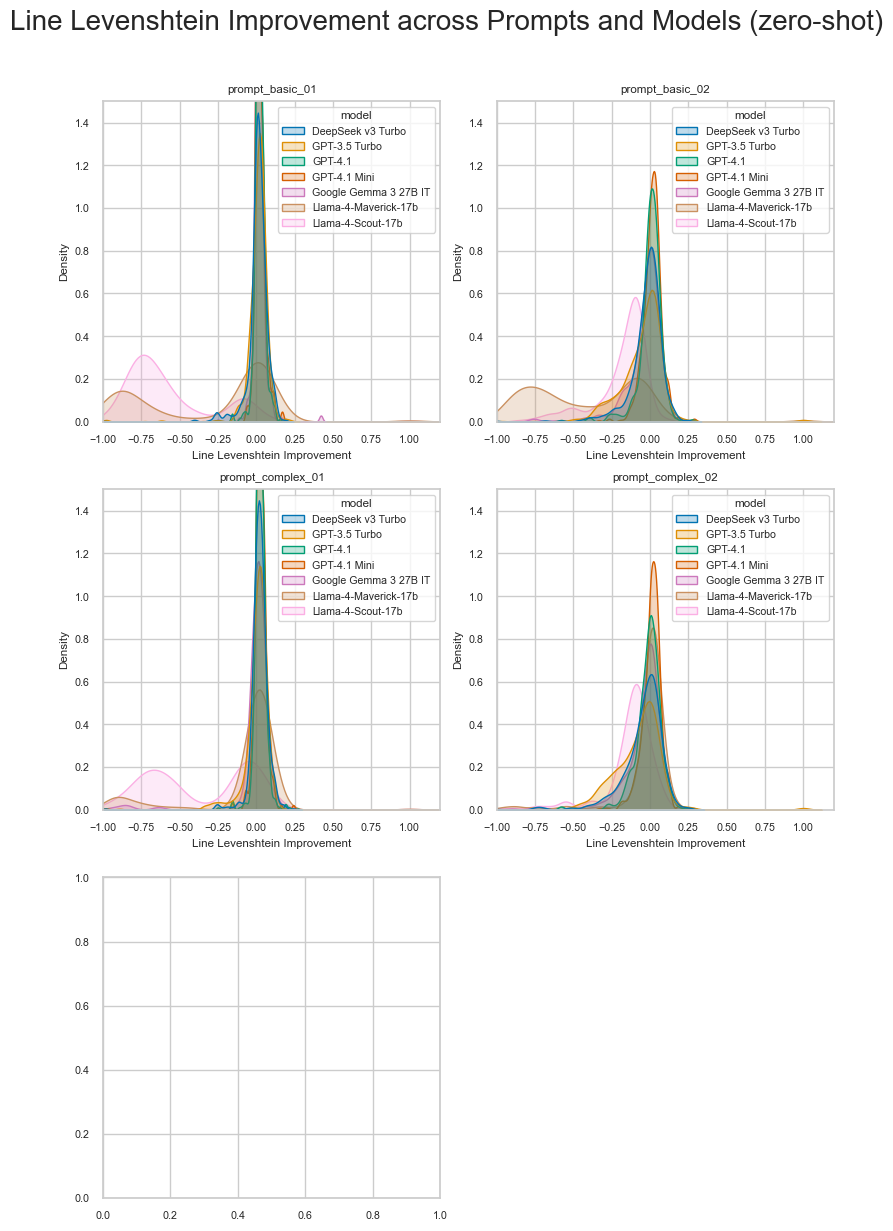

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=.7)

segmentations = ['line']

for type_of_experiment in ['zero-shot']:
    for error_rate in ['lev']:
        for segmentation in segmentations:
            fig, axs = plt.subplots(3, 2, figsize=(8, 12))  # Change here
            axs = axs.flatten()  # To make it easy to index

            for i, prompt in enumerate(prompt_names):
                prompt_data = data[(data.prompt == prompt)]
                prompt_data[f'{segmentation.capitalize()} Levenshtein Improvement'] = prompt_data[f'{segmentation}-{error_rate}-improvement']

                try:
                    if len(prompt_data) > 0:
                        sns.kdeplot(data=prompt_data, x=f'{segmentation.capitalize()} Levenshtein Improvement', 
                                    hue='model', fill=True, ax=axs[i], hue_order=MODELS)
                        axs[i].set_title(f'{prompt}')
                        axs[i].set_xlim([-1, 1.2])
                        axs[i].set_ylim([0, 1.5])
                except Exception as ex:
                    print(f'Could not plot {prompt} with {ex}')

            # Remove empty subplot
            fig.delaxes(axs[-1])  # Change here

            plt.suptitle(f'{segmentation.capitalize()} Levenshtein Improvement across Prompts and Models ({type_of_experiment})', fontsize=20, y=1.02)
            plt.tight_layout()
            plt.show()


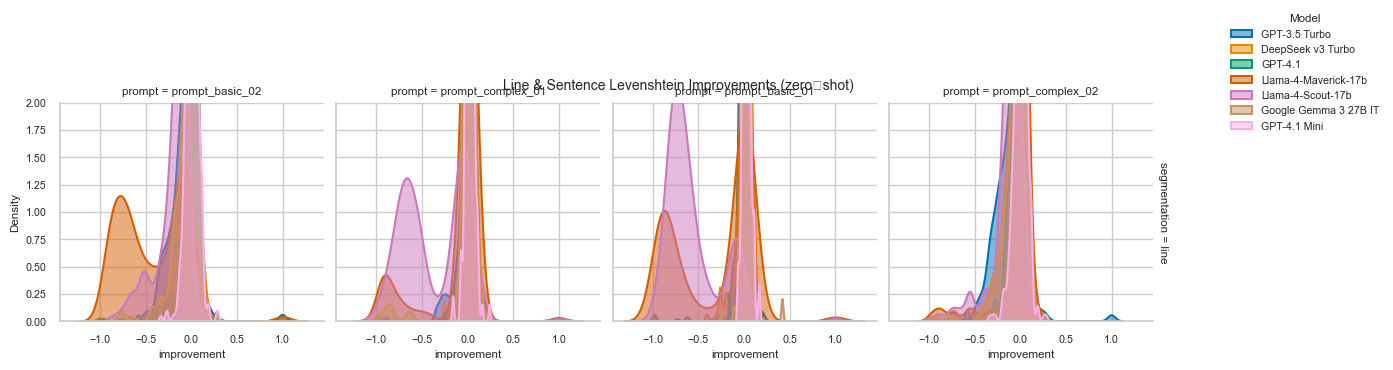

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# filter down to zero‑shot
zs = data.copy()

# melt only the two improvements
long = zs.melt(
    id_vars=['prompt','model'],
    value_vars=['line-lev-improvement'],
    var_name='segmentation', 
    value_name='improvement'
)
long['segmentation'] = long['segmentation'].str.split('-').str[0]

# facet by segmentation (rows) and prompt (cols)
g = sns.FacetGrid(
    long, 
    row='segmentation', 
    col='prompt', 
    hue='model',
    sharex=True,
    sharey=True,
    margin_titles=True,
    height=3
)

# Map only the KDE curves
g.map_dataframe(
    sns.kdeplot,
    x='improvement',
    common_norm=False,  # optional: normalizes each model separately
    fill=True,
    alpha=0.5,
    linewidth=1.5
)

# Clamp y-axis
g.set(ylim=(0, 2))

# Legend & title
g.add_legend(title='Model', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.subplots_adjust(top=0.9, right=0.85)
g.fig.suptitle('Line & Sentence Levenshtein Improvements (zero‑shot)')

plt.show()
